In [1]:
from enum import Enum
from numpy import random
from typing import Optional, Union, Dict, List, Tuple, Callable
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from scipy import integrate, special, stats
from math import exp, sqrt, pi, pow
import matplotlib.pyplot as plt
from pytest import raises

In [2]:
# from platform import python_version

# print(python_version())

In [3]:
import matplotlib
matplotlib.__version__

'3.2.2'

In [4]:
import os
# os.system("--NotebookApp.iopub_data_rate_limit=1.0e10")

In [5]:
default_random_seed = 42
random.seed(default_random_seed)

# Simulating the data

In [6]:
class Strata(Enum):
    AS = 0
    P = 1
    H = 2
    D = 3

    @classmethod
    def has_value(cls, value):
        return any(value == item.value for item in cls)

    @classmethod
    def safe_get_name(cls, value):
        try:
            return cls(value).name
        except ValueError:
            return "NA"

In [7]:
def get_strata(d0: int, d1: int) -> Strata:
    if d0==0:
        if d1==0:
            return Strata.AS
        else:
            return Strata.H
    else:
        if d1==0:
            return Strata.P
        else:
            return Strata.D


In [8]:
class GaussianDist():
    def __init__(self, n: int, param: Dict[str, float] = {'mu':0.0, 'sigma': 1.0}):
        v = random.normal(loc=param['mu'], scale=param['sigma'], size=n)
        self.sampled_vector = v if n>1 else v[0]


class UniformDist():
    def __init__(self, n: int, param: Dict[str, float] = {'a': -1.0, 'b': 1.0}):
        self.sampled_vector = random.uniform(low=param['a'], high=param['b'],
                                             size=n)

class BernoulliDist():
    def __init__(self, n: int, param: Dict[str, Union[float, np.array]] = {'p': 0.5}):
        self.sampled_vector = random.binomial(n=1, p=param['p'], size=n)



In [9]:
def generate_y(mu: float, strata: List[Strata], y_dist_param: Dict[str,float], t: int) -> List[Union[float, None]]:
    y = []
    relevant_strata = [Strata.AS.name, Strata.P.name] if t==1 else [Strata.AS.name, Strata.H.name]
    for mu_i, s in zip(mu, strata):
        if s not in relevant_strata:
            y.append(None)
        else:
            sigma = y_dist_param[f'sigma_{t}1'] if s==Strata.AS else y_dist_param[f'sigma_{t}0']
            y.append(GaussianDist(n=1, param={'mu': mu_i, 'sigma': sigma}).sampled_vector)
    return y

In [10]:
## Default Values ##
x_dist_default = UniformDist
# y0_dist_param_default = {'a0': 0.0, 'b0': 2.0, 'c0': 100.0, 'sigma_01': 1, 'sigma_00': 1}
# y1_dist_param_default = {'a1': 0.0, 'b1': 4.0, 'c1': 100.0, 'sigma_11': 1, 'sigma_10': 1}
y0_dist_param_default = {'a0': 0.0, 'b0': 2.0, 'c0': 10.0, 'sigma_01': 1, 'sigma_00': 1}
y1_dist_param_default = {'a1': 0.0, 'b1': 4.0, 'c1': 10.0, 'sigma_11': 1, 'sigma_10': 1}
treatment_prob_default = 0.5
omega_default = 1.0
beta_d_default = [-2.0, -2.0, 1.0]
# population_size_default = 10000
population_size_default = 1000

In [11]:
def generate_mu0_mu1(y0_dist_param: Dict[str,float],
                     y1_dist_param: Dict[str,float],
                     x: np.ndarray, s0: np.ndarray, s1: np.ndarray):
    mu0 = [(y0_dist_param['a0'] + y0_dist_param['b0']*x_i + y0_dist_param['c0']*s0_i) if s0_i is not None else None for x_i, s0_i in zip(x, s0)]
    mu1 = [(y1_dist_param['a1'] + y1_dist_param['b1']*x_i + y1_dist_param['c1']*s1_i) if s1_i is not None else None for x_i, s1_i in zip(x, s1)]
    return mu0,mu1
    

In [12]:
def create_sample(x_dist: Union[GaussianDist, UniformDist, float] = x_dist_default, 
                         y0_dist_param: Dict[str,float] = y0_dist_param_default,
                         y1_dist_param: Dict[str,float] = y1_dist_param_default,
                         treatment_prob : float = treatment_prob_default, 
                         omega: float = omega_default,
                         beta_d: List[float] = beta_d_default,
                         population_size: int = population_size_default,
                         random_seed: int = default_random_seed) -> pd.DataFrame:
    
    
    random.seed(random_seed)
    variables_dict = dict()
    
    if (x_dist==GaussianDist or x_dist==UniformDist):
        variables_dict['x'] = x_dist(n=population_size).sampled_vector
    else:
        variables_dict['x'] = np.full((population_size), x_dist)
    
    variables_dict['t'] = BernoulliDist(n=population_size, param={'p': treatment_prob}).sampled_vector
     
    D0_prob = [(1 / (1 + np.exp(-omega*(beta_d[0] + beta_d[1]*0 + beta_d[2]*variables_dict['x'][i])))) for i in range(0,population_size)]
    D1_prob = [(1 / (1 + np.exp(-omega*(beta_d[0] + beta_d[1]*1 + beta_d[2]*variables_dict['x'][i])))) for i in range(0,population_size)]
    variables_dict['D0'] = BernoulliDist(n=population_size, param={'p': D0_prob}).sampled_vector
    variables_dict['D1'] = BernoulliDist(n=population_size, param={'p': D1_prob}).sampled_vector

    variables_dict['stratum'] = [get_strata(d0, d1).name for d0, d1 in zip(variables_dict['D0'], variables_dict['D1'])]

    variables_dict['S1'] = [1 if s==Strata.AS.name else 0 if s==Strata.P.name else None for s in variables_dict['stratum']]
    variables_dict['S0'] = [1 if s==Strata.AS.name else 0 if s==Strata.H.name else None for s in variables_dict['stratum']]
    
    mu0, mu1 = generate_mu0_mu1(y0_dist_param, y1_dist_param, variables_dict['x'], variables_dict['S0'], variables_dict['S1'])
    
    
    variables_dict['Y0'] = generate_y(mu0, variables_dict['stratum'], y0_dist_param, 0)
    variables_dict['Y1'] = generate_y(mu1, variables_dict['stratum'], y1_dist_param, 1)

    variables_dict['D_obs'] = [d1 if t else d0 for t, d0, d1 in zip(variables_dict['t'], variables_dict['D0'], variables_dict['D1'])]
    variables_dict['Y_obs'] = [y1 if t else y0 for t, y0, y1 in zip(variables_dict['t'], variables_dict['Y0'], variables_dict['Y1'])]

    variables_dict['beta_d'] = [beta_d for i in range(0,population_size)]
    variables_dict['mu0'] = mu0
    variables_dict['mu1'] = mu1
    variables_dict['sigma_0'] = y0_dist_param['sigma_01']
    variables_dict['sigma_1'] = y1_dist_param['sigma_11']

    return pd.DataFrame.from_dict(variables_dict)
    

# $\pmb{\beta}_D$ 

## $\pmb{\beta}_D$ Manipulation analysis:


*   low $\beta_0$: higher chances of survival
*   low $\beta_1$: higher chances of survival under t=1 <- perhaps we can change D to be $\beta_1*(1-t)$ to control monotonicity!
*   low $\beta_2$: higher chances of survival for positive X, and the oposite of negative








In [13]:
def manipulate_beta_d():
    beta_d_list = [
    ([0.0, 0.0, 0.0], "beta's=0 -> 1/(1+e^0) -> death is random"),
    ([0.0, -5.0, 1.0], "low beta_1 -> higher chances of survival under t=1 -> mainly P and AS"),
    ([0.0, 10.0, 1.0], "high beta_1 -> lower chances of survival under t=1 -> mainly H and D"),
    ([0.0, 10.0, 10.0], "high beta_1 + high beta_2 -> lower chances of survival under t=1 -> mainly H and D"),
    ([-10.0, 10.0, 1.0], "high beta_1 + low beta_0 -> mainly H and AS"),
    ([-10.0, -10.0, 1.0], "low beta_1 + low beta_0 -> mainly AS"),
    ([-2.0, -2.0, 1.0], "low beta_1 + low beta_0 -> mainly AS, less extreme"),
    ]

    for beta_d_i, desc in beta_d_list:
        df = create_sample(beta_d = beta_d_i)
        print(f"for beta_D {beta_d_i} ({desc}):")
        display(pd.DataFrame({"count":df.stratum.value_counts(),"%":df.stratum.value_counts(normalize=True)*100}))
        print("\n\n")

    # Understand X effect (beta_2)

In [14]:
manipulate_beta_d()

for beta_D [0.0, 0.0, 0.0] (beta's=0 -> 1/(1+e^0) -> death is random):


,count,%
AS,259,25.9
P,253,25.3
D,249,24.9
H,239,23.9





for beta_D [0.0, -5.0, 1.0] (low beta_1 -> higher chances of survival under t=1 -> mainly P and AS):


,count,%
AS,511,51.1
P,481,48.1
H,5,0.5
D,3,0.3





for beta_D [0.0, 10.0, 1.0] (high beta_1 -> lower chances of survival under t=1 -> mainly H and D):


,count,%
H,516,51.6
D,484,48.4





for beta_D [0.0, 10.0, 10.0] (high beta_1 + high beta_2 -> lower chances of survival under t=1 -> mainly H and D):


,count,%
D,482,48.2
H,480,48.0
AS,38,3.8





for beta_D [-10.0, 10.0, 1.0] (high beta_1 + low beta_0 -> mainly H and AS):


,count,%
H,507,50.7
AS,493,49.3





for beta_D [-10.0, -10.0, 1.0] (low beta_1 + low beta_0 -> mainly AS):


,count,%
AS,1000,100.0





for beta_D [-2.0, -2.0, 1.0] (low beta_1 + low beta_0 -> mainly AS, less extreme):


,count,%
AS,848,84.8
P,134,13.4
H,14,1.4
D,4,0.4


## $\pmb{\beta}_D$ Estimation:



### Estimating $\pmb{\beta}_D$ from the observed realizations

In [15]:
def estimate_beta_d_from_realizations(true_beta_d_for_estimation: List[float],
                                      df: Optional[pd.DataFrame] = None) -> List[float]:
    if type(df) != pd.DataFrame and df == None:
        df = create_sample(beta_d = true_beta_d_for_estimation)
    
    features = [[t_i, x_i] for t_i, x_i in zip(list(df.t), list(df.x))]
    # y = df['D0'].where(df['t'] == 0, df['D1']) # observed D
    y = df['D_obs']
    
    clf = LogisticRegression(random_state=0).fit(features, y)
    
    beta_d_hat = [round(float(clf.intercept_),2)] + [round(beta,2) for beta in list(clf.coef_[0])]
    print(f"beta_d_hat: {beta_d_hat}")
    print(f"(True beta_d: {true_beta_d_for_estimation})")

    # unique, counts = np.unique(clf.predict(features), return_counts=True)
    # print(f"values count for y_hat: {dict(zip(unique, counts))}")
    # unique, counts = np.unique(y, return_counts=True)
    # print(f"values count for : {dict(zip(unique, counts))}")
    
    return beta_d_hat

In [16]:
estimate_beta_d_from_realizations([0.01, -5.0, 1.0])
print("\n****\n")
estimate_beta_d_from_realizations([-2.0, -2.0, 1.0])

beta_d_hat: [-0.07, -4.1, 0.94]
(True beta_d: [0.01, -5.0, 1.0])

****

beta_d_hat: [-1.99, -1.68, 0.63]
(True beta_d: [-2.0, -2.0, 1.0])


[-1.99, -1.68, 0.63]

### Using both D's (potential outecomes)


Using sklearn's LogisticRegression.<br>
Note that for both $D(0)$ and $D(1)$-> there is only $\beta_0 + \beta_2\cdot x$:<br>


*   $D(0)$: $\beta_0 + \beta_1\cdot 0 + \beta_2\cdot x = \beta_0 + \beta_2\cdot x$<br> 
*   $D(1)$: $\beta_0 + \beta_1\cdot 1 + \beta_2\cdot x = \underbrace{\beta_0 +  \beta_1}_{\beta_0'} + \beta_2\cdot x = \beta_0' + \beta_2\cdot x$

Final $\hat{\pmb{\beta}}_D$ will be assembled like so:<br>


*   $\hat{\beta}_0 = \hat{\beta}_0(0)$
*   $\hat{\beta}_1 = \underbrace{\hat{\beta}_0(1)}_{:=\beta_0'} - \hat{\beta}_0(0)$
*   $\hat{\beta}_2 = $ Average of $\hat{\beta}_2(0)$ and $\hat{\beta}_2(1)$

In [17]:
def estimate_beta_d(true_beta_d_for_estimation: List[float], 
                    df: Optional[pd.DataFrame]=None):
    if df == None:
        df = create_sample(beta_d = true_beta_d_for_estimation)
    
    features = [[x_i] for x_i in list(df.x)]
    y = list(df.D0)
    clf = LogisticRegression(random_state=0).fit(features, y)
    beta_d_hat_t0 = [round(float(clf.intercept_),2)] + [round(beta,2) for beta in list(clf.coef_[0])]
    print("for T=0:")
    print(f"beta_d_hat: {beta_d_hat_t0}")

    # unique, counts = np.unique(clf.predict(features), return_counts=True)
    # print(f"values count for y_hat: {dict(zip(unique, counts))}")
    # unique, counts = np.unique(y, return_counts=True)
    # print(f"values count for : {dict(zip(unique, counts))}")

    y = list(df.D1)
    clf = LogisticRegression(random_state=0).fit(features, y)
    beta_d_hat_t1 = [round(float(clf.intercept_),2)] + [round(beta,2) for beta in list(clf.coef_[0])]
    print("for T=0:")
    print(f"beta_d_hat: {beta_d_hat_t1}")   

    combined_beta_d = [beta_d_hat_t0[0], beta_d_hat_t1[0]-beta_d_hat_t0[0], np.mean([beta_d_hat_t0[1], beta_d_hat_t1[1]])]
    combined_beta_d = [round(beta,2) for beta in combined_beta_d]
    print(f"\nCombining both: {combined_beta_d}")
    print(f"(True beta_d: {true_beta_d_for_estimation})")
    


In [18]:
estimate_beta_d([0.01, -5.0, 1.0])
print("\n****\n")
estimate_beta_d([-2.0, -2.0, 1.0])


for T=0:
beta_d_hat: [-0.05, 0.87]
for T=0:
beta_d_hat: [-4.82, -0.0]

Combining both: [-0.05, -4.77, 0.44]
(True beta_d: [0.01, -5.0, 1.0])

****

for T=0:
beta_d_hat: [-1.97, 1.16]
for T=0:
beta_d_hat: [-4.07, 0.71]

Combining both: [-1.97, -2.1, 0.94]
(True beta_d: [-2.0, -2.0, 1.0])


# $\pi$ - Strata proportions estimation

In [19]:
def bound_strata_proportions(df: pd.DataFrame) -> Dict[Strata, Tuple[float, float]]:
    p_t1_d0 = df.loc[(df.D1==0)&(df.t==1)].shape[0]/df.loc[df.t==1].shape[0]
    p_t0_d0 = df.loc[(df.D0==0)&(df.t==0)].shape[0]/df.loc[df.t==0].shape[0]

    pi_h_lower = max(0, p_t0_d0 - p_t1_d0)
    pi_h_upper = min(p_t0_d0, 1 - p_t1_d0)

    pi_as_lower = p_t0_d0 - pi_h_upper
    pi_as_upper = p_t0_d0 - pi_h_lower

    pi_p_lower = p_t1_d0 - pi_as_upper
    pi_p_upper = p_t1_d0 - pi_as_lower

    pi_d_lower = 1 - p_t1_d0 - pi_h_upper
    pi_d_upper = 1 - p_t1_d0 - pi_h_lower

    return {Strata.H: (pi_h_lower, pi_h_upper), Strata.AS: (pi_as_lower, pi_as_upper), 
            Strata.P: (pi_p_lower, pi_p_upper), Strata.D: (pi_d_lower, pi_d_upper)}


In [20]:
def check_strata_for_different_beta(beta_d_list: List[float] = [[0.0, 0.0, 0.0], [-2.0, -2.0, 1.0], [0.0, 5.0, 0.0], [0.0, 10.0, 0.0]]):
    for beta_d in beta_d_list:
        print(f"\nfor beta_d={beta_d}:")
        sample_for_bounds = create_sample(beta_d = beta_d)
        prprtn_bounds = bound_strata_proportions(sample_for_bounds)

        for stratum , bounds in prprtn_bounds.items():
            true_pi  = round(100*sample_for_bounds.loc[sample_for_bounds.stratum==stratum.name].shape[0]/sample_for_bounds.shape[0],2)
            lower_bound = round(100*bounds[0],2)
            upper_bound = round(100*bounds[1],2)
            
            within_bounds = "✔" if lower_bound<=true_pi<=upper_bound else "✘"
            
            print(f"Stratum {stratum.name} real value is: {true_pi}%, and it is bounded by: [{lower_bound}%, {upper_bound}%]   {within_bounds}")

check_strata_for_different_beta()


for beta_d=[0.0, 0.0, 0.0]:
Stratum H real value is: 23.9%, and it is bounded by: [0%, 48.64%]   ✔
Stratum AS real value is: 25.9%, and it is bounded by: [0.74%, 49.38%]   ✔
Stratum P real value is: 25.3%, and it is bounded by: [1.98%, 50.62%]   ✔
Stratum D real value is: 24.9%, and it is bounded by: [0.0%, 48.64%]   ✔

for beta_d=[-2.0, -2.0, 1.0]:
Stratum H real value is: 1.4%, and it is bounded by: [0%, 2.33%]   ✔
Stratum AS real value is: 84.8%, and it is bounded by: [85.07%, 87.4%]   ✘
Stratum P real value is: 13.4%, and it is bounded by: [10.28%, 12.6%]   ✘
Stratum D real value is: 0.4%, and it is bounded by: [0.0%, 2.33%]   ✔

for beta_d=[0.0, 5.0, 0.0]:
Stratum H real value is: 49.4%, and it is bounded by: [48.6%, 49.38%]   ✘
Stratum AS real value is: 0.4%, and it is bounded by: [0.0%, 0.78%]   ✔
Stratum P real value is: 0.3%, and it is bounded by: [-0.0%, 0.78%]   ✔
Stratum D real value is: 49.9%, and it is bounded by: [49.84%, 50.62%]   ✔

for beta_d=[0.0, 10.0, 0.0]:
Stratu

Interesting to see the results for extreme distribution (for example with $\beta_D=[0,10,0]$)

# $Y(t)|X,S_t=1$


In [21]:
# sample_for_y_dist = create_sample(
#     y0_dist_param ={'a0': 0.0, 'b0': 2.0, 'c0': 100.0, 'sigma_01': 1, 'sigma_00': 1} , 
#     y1_dist_param = {'a1': 0.0, 'b1': 4.0, 'c1': 100.0, 'sigma_11': 1, 'sigma_10': 1})

sample_for_y_dist = create_sample()
print("\nExample from each strata:")
sample_for_y_dist.groupby("stratum").sample(n=3, random_state=1)


Example from each strata:


,x,t,D0,D1,stratum,S1,S0,Y0,Y1,D_obs,Y_obs,beta_d,mu0,mu1,sigma_0,sigma_1
577,0.853175,1,0,0,AS,1.0,1.0,11.855714,14.605814,0,14.605814,"[-2.0, -2.0, 1.0]",11.706351,13.412701,1,1
658,0.291834,0,0,0,AS,1.0,1.0,9.383971,11.009591,0,9.383971,"[-2.0, -2.0, 1.0]",10.583669,11.167338,1,1
220,0.315226,1,0,0,AS,1.0,1.0,9.665746,11.182672,0,11.182672,"[-2.0, -2.0, 1.0]",10.630452,11.260903,1,1
789,0.894567,1,1,1,D,NaN,NaN,NaN,NaN,1,NaN,"[-2.0, -2.0, 1.0]",NaN,NaN,1,1
506,0.821854,1,1,1,D,NaN,NaN,NaN,NaN,1,NaN,"[-2.0, -2.0, 1.0]",NaN,NaN,1,1
431,0.523021,1,1,1,D,NaN,NaN,NaN,NaN,1,NaN,"[-2.0, -2.0, 1.0]",NaN,NaN,1,1
55,0.843748,0,0,1,H,NaN,0.0,1.010502,NaN,0,1.010502,"[-2.0, -2.0, 1.0]",1.687497,NaN,1,1
407,-0.978325,1,0,1,H,NaN,0.0,-1.481219,NaN,1,NaN,"[-2.0, -2.0, 1.0]",-1.956649,NaN,1,1
444,0.625599,1,0,1,H,NaN,0.0,1.564330,NaN,1,NaN,"[-2.0, -2.0, 1.0]",1.251198,NaN,1,1
736,-0.215110,0,1,0,P,0.0,NaN,NaN,-0.364634,1,NaN,"[-2.0, -2.0, 1.0]",NaN,-0.860439,1,1


## Analyzing sample of same x

In [22]:
sample_with_same_x = create_sample(x_dist=0.2)
sample_with_same_x.groupby("stratum").sample(n=3, random_state=1)

,x,t,D0,D1,stratum,S1,S0,Y0,Y1,D_obs,Y_obs,beta_d,mu0,mu1,sigma_0,sigma_1
950,0.2,1,0,0,AS,1.0,1.0,10.509408,10.802288,0,10.802288,"[-2.0, -2.0, 1.0]",10.4,10.8,1,1
641,0.2,0,0,0,AS,1.0,1.0,9.873752,11.280908,0,9.873752,"[-2.0, -2.0, 1.0]",10.4,10.8,1,1
980,0.2,0,0,0,AS,1.0,1.0,10.069211,10.812829,0,10.069211,"[-2.0, -2.0, 1.0]",10.4,10.8,1,1
314,0.2,1,0,1,H,NaN,0.0,1.674875,NaN,1,NaN,"[-2.0, -2.0, 1.0]",0.4,NaN,1,1
27,0.2,1,0,1,H,NaN,0.0,-0.716524,NaN,1,NaN,"[-2.0, -2.0, 1.0]",0.4,NaN,1,1
165,0.2,1,0,1,H,NaN,0.0,2.119378,NaN,1,NaN,"[-2.0, -2.0, 1.0]",0.4,NaN,1,1
60,0.2,0,1,0,P,0.0,NaN,NaN,0.846003,1,NaN,"[-2.0, -2.0, 1.0]",NaN,0.8,1,1
700,0.2,1,1,0,P,0.0,NaN,NaN,0.943049,0,0.943049,"[-2.0, -2.0, 1.0]",NaN,0.8,1,1
74,0.2,1,1,0,P,0.0,NaN,NaN,2.155443,0,2.155443,"[-2.0, -2.0, 1.0]",NaN,0.8,1,1


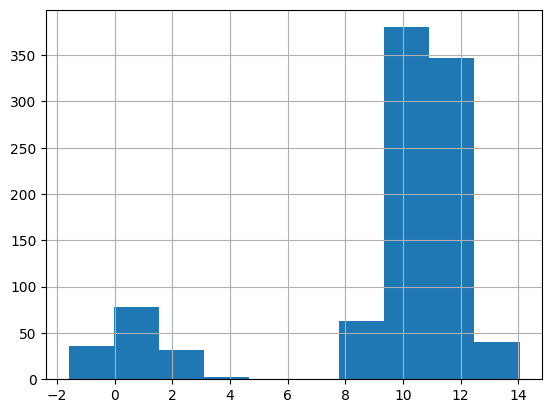

In [23]:
# sample_with_same_x.loc[sample_with_same_x.stratum==Strata.P.name]['Y1'].hist()
sample_with_same_x['Y1'].hist()

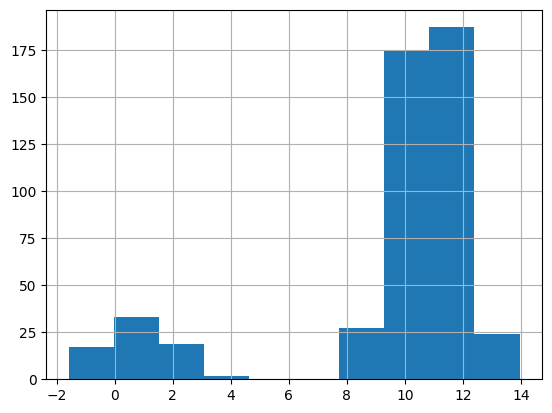

In [24]:
# sample_with_same_x.loc[(sample_with_same_x.stratum==Strata.P.name) & (sample_with_same_x.t==1) & (sample_with_same_x['D1']==0)]['Y1'].hist()
sample_with_same_x.loc[(sample_with_same_x.t==1) & (sample_with_same_x['D1']==0)]['Y1'].hist()

## True value (for known $i\in AS$):

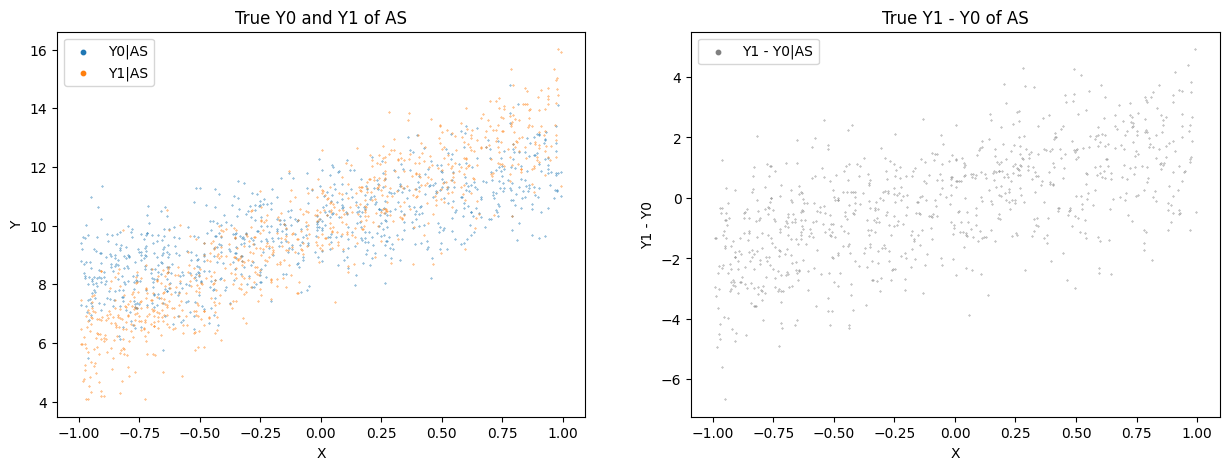

In [25]:
def plot_true_y0_y1_for_as(df: pd.DataFrame) -> None:
    df_plot_as = df.loc[df.stratum==Strata.AS.name]

    figure, ax = plt.subplots(1, 2,figsize=(15,5))
    
    ax[0].scatter(df_plot_as.x, df_plot_as.Y0, label = "Y0|AS", s=0.1)
    ax[0].scatter(df_plot_as.x, df_plot_as.Y1, label = "Y1|AS", s=0.1)
    ax[0].set_title("True Y0 and Y1 of AS")
    ax[0].set_xlabel('X')
    ax[0].set_ylabel('Y')
    ax[0].legend(markerscale=10)

    ax[1].scatter(df_plot_as.x, df_plot_as.Y1 - df_plot_as.Y0, label = "Y1 - Y0|AS", s=0.1, color = "grey")
    ax[1].set_title("True Y1 - Y0 of AS")
    ax[1].set_xlabel('X')
    ax[1].set_ylabel('Y1 - Y0')
    ax[1].legend(markerscale=10)
    
    plt.show()

plot_true_y0_y1_for_as(sample_for_y_dist)

## Using observational data:

1.   Zhang & Rubin
2.   Using the parametric assumptions - Y is normal, estimate mu out of two mixed gaussians that differ by one latent variable

### 1. Zhang & Rubin

#### Non parametric

##### Non parametric helping functions

In [26]:
def calc_non_parametric_p_t0d0_p_t1d0(df: pd.DataFrame) -> Tuple[float]:
    p_t0d0 = df.loc[(df.D_obs==0) & (df.t==0)].shape[0] / df.loc[df.t==0].shape[0]
    p_t1d0 = df.loc[(df.D_obs==0) & (df.t==1)].shape[0] / df.loc[df.t==1].shape[0]
    return p_t0d0, p_t1d0

In [27]:
def get_y_0_obs_y_1_obs(df: pd.DataFrame) -> Tuple[np.ndarray]:
    y_0_obs = df.loc[df.t==0]['Y0'].dropna()
    y_1_obs = df.loc[df.t==1]['Y1'].dropna()
    return y_0_obs, y_1_obs


In [28]:
def get_q1_q2(p_t0d0: float, p_t1d0: float, pi_h: float) -> Tuple[float]:
    q1 = p_t0d0/p_t1d0-pi_h/p_t1d0
    q2 = 1-pi_h/p_t0d0
    return q1, q2

In [29]:
def calc_non_parametric_zhang_rubin_given_arg(y_0_obs: np.ndarray, y_1_obs: np.ndarray, q1: float, q2:float) ->  Tuple[float]:
    y_0_obs_sorted = np.sort(y_0_obs)
    y_1_obs_sorted = np.sort(y_1_obs)
    zhang_rubin_lb = np.average(y_1_obs_sorted[0 : round(len(y_1_obs_sorted) * q1)]) - np.average(y_0_obs_sorted[round(len(y_0_obs_sorted) * (1-q2)) : len(y_0_obs_sorted)])
    zhang_rubin_ub = np.average(y_1_obs_sorted[round(len(y_1_obs_sorted) * (1-q1)) : len(y_1_obs_sorted)]) - np.average(y_0_obs_sorted[0 : round(len(y_0_obs_sorted) * q2)])
    return zhang_rubin_lb, zhang_rubin_ub

##### Non parametric bounds

In [30]:
def calc_non_parametric_zhang_rubin(sample_df: pd.DataFrame, 
                                           plot_and_print: bool = False, 
                                           pi_h_step: float = 0.001):

    p_t0d0, p_t1d0 = calc_non_parametric_p_t0d0_p_t1d0(sample_df)
    lower_pi = max(0, p_t0d0-p_t1d0)
    upper_pi = min(p_t0d0, 1-p_t1d0)
    pi_h_list = np.arange(lower_pi, upper_pi + pi_h_step, pi_h_step)

    y_0_obs, y_1_obs = get_y_0_obs_y_1_obs(sample_df)

    # bounds
    zhang_rubin_lb_results = []
    zhang_rubin_ub_results = []
    for pi_h in pi_h_list:
        q1, q2 = get_q1_q2(p_t0d0, p_t1d0, pi_h)
        zhang_rubin_lb, zhang_rubin_ub = calc_non_parametric_zhang_rubin_given_arg(y_0_obs, y_1_obs, q1, q2)

        if plot_and_print:
            print(f"""pi_h {round(pi_h,3)}:
            Zhang and Rubin bounds are [{zhang_rubin_lb}, {zhang_rubin_ub}]
            """)
        zhang_rubin_lb_results.append(zhang_rubin_lb)
        zhang_rubin_ub_results.append(zhang_rubin_ub)

    zhang_rubin_lb = np.nanmin(zhang_rubin_lb_results)
    zhang_rubin_ub = np.nanmax(zhang_rubin_ub_results)

    return (zhang_rubin_lb, zhang_rubin_ub)


In [31]:
def non_parametric_zhang_rubin_main(df: pd.DataFrame) -> None:
    zhang_rubin_lb, zhang_rubin_ub = calc_non_parametric_zhang_rubin(sample_for_y_dist)
    print(f"Bounds by Zhang and Rubin: [{zhang_rubin_lb}, {zhang_rubin_ub}]")
    as_df = df.loc[df.stratum==Strata.AS.name]
    print(f"Actual AS treatment effect: {(as_df.Y1-as_df.Y0).mean()}")

non_parametric_zhang_rubin_main(sample_for_y_dist)

Bounds by Zhang and Rubin: [-2.0912030387305185, -0.050238004648200274]
Actual AS treatment effect: -0.19863522085628715


#### Parametric

Lower bound:
$min_{\pi_h}\left[ \bar{Y}^{obs}(1)_{\left[0,\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right]} - \bar{Y}^{obs}(0)_{\left[\frac{\pi_h}{P_{T=1,D=0}},1\right]} \right]$<br>
Upper bound:
$max_{\pi_h}\left[ \bar{Y}^{obs}(1)_{\left[1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}},1\right]} - \bar{Y}^{obs}(0)_{\left[0,1-\frac{\pi_h}{P_{T=1,D=0}}\right]} \right]$ <br><br>

$\bar{Y}^{obs}(1)_{\left[0,\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right]} \rightarrow \int_{\Phi_{Y_{(1)}}^{-1}(0)}^{\Phi_{Y_{(1)}}^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)} y\cdot f_{Y|X}(y|x)\,dy = \int_{\Phi_{Y_{(1)}}^{-1}(0)}^{\Phi_{Y_{(1)}}^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)} y\cdot\frac{1}{\sigma_{Y_{(1)}}\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu_{Y_{(1)}}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,dy$<br><br>

$\mu_{y_{(1)}}=E[Y|T=1,X=x]$ <br>
Let us assume that: $\mu_{y_{(1)}}=E[Y|T=1,X=x]:=\bar{\beta}_0+\bar{\beta_1} x$.
Then when can estimate the $\bar{\beta}_i$s and assign this linear equation as $\mu_{y_{(1)}}$ (It didn't have to be linear, it could have been polynomila, NN, anything). <br> <br> <br>

 $\int_{\Phi^{-1}(0)}^{\Phi^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)} y\cdot\frac{1}{\sigma_{Y_{(1)}}\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\left(\frac{y-\mu_{Y_{(1)}}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,dy$
  <br>
$\hat{y}=y-\mu_{Y_{(1)}} \overset{\frac{d\hat{y}}{dy}=\frac{d}{dy}(y-\mu_{Y_{(1)}})=1}{\longrightarrow} d\hat{y}=dy$
  <br><br>
$\Longrightarrow\int_{\Phi^{-1}(0)}^{\Phi^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)} \overbrace{y}^{\hat{y}+\mu_{Y_{(1)}}}\cdot\frac{1}{\sigma_{Y_{(1)}}\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\left(\frac{\overbrace{y-\mu_{Y_{(1)}}}^{=\hat{y}}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,\overbrace{dy}^{d\hat{y}} =$
$\int_{\Phi^{-1}(0)-\mu_{Y_{(1)}}}^{\Phi^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu_{Y_{(1)}}} (\hat{y}+\mu_{Y_{(1)}})\cdot\frac{1}{\sigma_{Y_{(1)}}\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\left(\frac{\hat{y}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,d\hat{y} = $
$\int_{\Phi^{-1}(0)-\mu_{Y_{(1)}}}^{\Phi^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu_{Y_{(1)}}} (\hat{y}+\mu_{Y_{(1)}})\cdot\frac{1}{\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\left(\frac{\hat{y}}{\sigma_{Y_{(1)}}}\right)^{\!2}\,\right)\,\frac{d\hat{y}}{\sigma_{Y_{(1)}}}
$
<br><br>
$\tilde{y}=\hat{y}/\sigma_{Y_{(1)}}\overset{\frac{d\tilde{y}}{d\hat{y}}=\frac{d}{d\hat{y}}\hat{y}/\sigma_{Y_{(1)}}=1/\sigma_{Y_{(1)}}}{\longrightarrow}d\tilde{y}=\frac{d\hat{y}}{\sigma_{Y_{(1)}}}$
<br><br>
$\Longrightarrow 
\int_{\Phi^{-1}(0)-\mu_{Y_{(1)}}}^{\Phi^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu_{Y_{(1)}}} (\overbrace{\hat{y}}^{\tilde{y}\sigma_{Y_{(1)}}}+\mu_{Y_{(1)}})\cdot\frac{1}{\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\left(\overbrace{\frac{\hat{y}}{\sigma_{Y_{(1)}}}}^{\tilde{y}}\right)^{2}\,\right)\,\overbrace{\frac{d\hat{y}}{\sigma_{Y_{(1)}}}}^{d\tilde{y}}=$
$\int_{\frac{\Phi^{-1}(0)-\mu_{Y_{(1)}}}{\sigma_{Y_{(1)}}}}^{\frac{\Phi^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu_{Y_{(1)}}}{\sigma_{Y_{(1)}}}} (\tilde{y}\sigma_{Y_{(1)}}+\mu_{Y_{(1)}})\cdot\underbrace{\frac{1}{\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\tilde{y}^{2}\,\right)}_{\text{pdf of s.n.}}\,d\tilde{y}
$

<br><br><br>
$\bar{Y}^{obs}(1)_{\left[0,\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right]} \rightarrow \left(\int_{\frac{\Phi^{-1}(0)-\mu_{Y_{(1)}}}{\sigma_{Y_{(1)}}}}^{\Phi^{-1}\frac{\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu_{Y_{(1)}}}{\sigma_{Y_{(1)}}}} (\tilde{y}\sigma_{Y_{(1)}}+\mu_{Y_{(1)}})\cdot\underbrace{\varphi(\tilde{y})}_{\text{pdf of s.n.}}\,d\tilde{y} \right) $<br><br><br>

Therefor bounds are:<br>
Lower bound:
$min_{\pi_h}\left[ \left(\int_{\frac{\Phi^{-1}(0)-\mu_{Y_{(1)}}}{\sigma_{Y_{(1)}}}}^{\frac{\Phi^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu_{Y_{(1)}}}{\sigma_{Y_{(1)}}}} (y\sigma_{Y_{(1)}}+\mu_{Y_{(1)}})\cdot\varphi(y)\,dy \right)  - \left(\int_{\frac{\Phi^{-1}\left(\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu_{Y_{(0)}}}{\sigma_{Y_{(0)}}}}^{\frac{\Phi^{-1}(1)-\mu_{Y_{(0)}}}{\sigma_{Y_{(0)}}}} (y\sigma_{Y_{(0)}}+\mu_{Y_{(0)}})\cdot\varphi(y)\,dy \right)\right]$<br>
Upper bound:
$max_{\pi_h}\left[ \left(\int_{\frac{\Phi^{-1}\left(1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu_{Y_{(1)}}}{\sigma_{Y_{(1)}}}}^{\frac{\Phi^{-1}(1)-\mu_{Y_{(1)}}}{\sigma_{Y_{(1)}}}} (y\sigma_{Y_{(1)}}+\mu_{Y_{(1)}})\cdot\varphi(y)\,dy \right)  - \left(\int_{\frac{\Phi^{-1}(0)-\mu_{Y_{(0)}}}{\sigma_{Y_{(0)}}}}^{\frac{\Phi^{-1}\left(1-\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu_{Y_{(0)}}}{\sigma_{Y_{(0)}}}} (y\sigma_{Y_{(0)}}+\mu_{Y_{(0)}})\cdot\varphi(y)\,dy \right) \right]$
<br><br><br>

$P_{T=0,D=0}=\frac{\#\{D_i=0 \& T_i=0\}}{\#\{T_i=0\}}=p(D_i=0|T_i=0, X=x)= 1- \frac{1}{1+\exp\{(-{\beta_D}^\top [1,t=0,x])\}}=1- \frac{1}{1+\exp\{(-\beta_0-\beta_2x)\}}$<br>
$P_{T=1,D=0}=\frac{\#\{D_i=0 \& T_i=1\}}{\#\{T_i=1\}}=p(D_i=0|T_i=1, X=x)= 1- \frac{1}{1+\exp\{(-{\beta_D}^\top [1,t=1,x])\}}=1- \frac{1}{1+\exp\{(-\beta_0-\beta_1-\beta_2x)\}}$<br>
$\pi_h: \max\left(0,\overbrace{1-\frac{1}{1+\exp\{(-\beta_0-\beta_2x)\}}}^{P_{T=0,D=0}} - \overbrace{1- \frac{1}{1+\exp\{(-\beta_0-\beta_1-\beta_2x)\}}}^{P_{P_{T=1,D=0}}}\right)  \leq\pi_h\leq  \min\left(\overbrace{1-\frac{1}{1+\exp\{(-\beta_0-\beta_2x)\}}}^{P_{T=0,D=0}}, 1- \left( \overbrace{1- \frac{1}{1+\exp\{(-\beta_0-\beta_1-\beta_2x)\}}}^{P_{T=1,D=0}}\right)\right)$

##### Parametric helping functions

In [32]:
def calculate_integral(func, lower_limit_integration, upper_limit_integration):
    integral_result, estimate_absolute_error = integrate.quad(func, lower_limit_integration, upper_limit_integration)
    return integral_result

In [33]:
## PLOTS ##
def plot_integrand_function(y_phi: Callable[[float], float], pi_h_step: float):
    min_y_phi, max_y_phi = -7.5, 7.5
    y_values, y_phi_values = zip(*[(y, y_phi(y)) for y in np.arange(min_y_phi, max_y_phi, pi_h_step)])
    plt.figure(figsize=(15, 3))
    plt.title (r'Plot of the integrand $y\cdot\varphi(y)$')
    plt.xlabel(r'$y$')
    plt.ylabel(r'$y\cdot\varphi(y)$')
    plt.plot(y_values, y_phi_values)
    plt.show()

def plot_pi_h(lower_pi: float, upper_pi: float):
    plt.plot((lower_pi,upper_pi),(1,1),'ro-',color='orange')
    plt.annotate(r'$max(0,P_{T=0,D=0}-P_{T=1,D=0})$', (lower_pi,1.005))
    plt.annotate(round(lower_pi,3), (lower_pi,1))
    plt.annotate(r'$min(P_{T=0,D=0},1-P_{T=1,D=0})$', (upper_pi,1.005))
    plt.annotate(round(upper_pi,3), (upper_pi,1))
    plt.xlim(lower_pi-0.005, upper_pi+0.005)
    plt.yticks([])
    axes = plt.gca()
    plt.box(False)
    plt.xlabel(r'$\pi_h$')
    plt.show()

def plot_pi_h_and_bounds(pi_h: List[float], zhang_rubin_lb: List[float], zhang_rubin_ub: List[float]):
    plt.scatter(pi_h, zhang_rubin_lb, label = "zhang_rubin_lb" , s=2.5)
    plt.scatter(pi_h, zhang_rubin_ub, label = "zhang_rubin_ub", s=2.5)
    # plt.legend(markerscale=10)
    plt.legend()
    plt.title (r"Grid search of $\pi_h$ and Zhang & Rubin's")
    plt.xlabel(r'$\pi_h$')
    plt.ylabel(r'Zhang & Rubin Bounds')
    plt.show()


##### $\Phi^{-1}(\alpha)=P(Y<F^{-1}(\alpha))$, where $F^{-1}(\alpha)$ is the $\alpha$ quantile of $Y$. <br>
First we'll calculate the quantile using binary search, and then we'll calculate the cdf of that quantile.

In [34]:
def continuous_bisect_fun_left(f, v, lo, hi):
    # Return the smallest value x between lo and hi such that f(x) >= v
    val_range = [lo, hi]
    k = 0.5 * sum(val_range)
    for i in range(32): #TODO WHY 32
        val_range[int(f(k) > v)] = k
        next_k = 0.5 * sum(val_range)
        if next_k == k:
            break
        k = next_k
    return k

def get_mixture_cdf(component_distributions, ps):
    # Return the function that is the cdf of the mixture distribution
    return lambda x: sum(component_dist.cdf(x) * p for component_dist, p in zip(component_distributions, ps))

def mixture_quantile(p, component_distributions, ps):
    # Return the pth quantile of the mixture distribution given by the component distributions and their probabilities
    mixture_cdf = get_mixture_cdf(component_distributions, ps)

    lo = np.min([dist.ppf(p) for dist in component_distributions])
    hi = np.max([dist.ppf(p) for dist in component_distributions])

    return continuous_bisect_fun_left(mixture_cdf, p, lo, hi)

def cdf_of_mixture_of_quantile(f1, f2, quantile, weight):
    ps_component1 = f1.cdf(quantile)
    ps_component2 = f2.cdf(quantile)
    ps_mixture = weight * ps_component1 + (1-weight) * ps_component2
    return ps_mixture


def get_ndtri_of_mix(alpha, component_distributions, ps, weight):
    quantile = mixture_quantile(alpha, component_distributions, ps)
    ndtri_mix = cdf_of_mixture_of_quantile(component_distributions[0], component_distributions[0], quantile, weight)
    return ndtri_mix

In [35]:
def calculate_integral_bounds(component_distributions, weight, ps, alpha_list, mu, sigma):
    argmt_integral_list = []
    for alpha in alpha_list:
        if alpha == 0:
            ndtri_mix = 0.0 # alpha=0 -> quantile=-inf -> ndtri=0
        elif alpha == 1:
            ndtri_mix = 1.0 # alpha=1 -> quantile=inf -> ndtri=1
        else:
            ndtri_mix = get_ndtri_of_mix(alpha, component_distributions, ps, weight)
        argmt_integral_list.append((ndtri_mix-mu)/sigma)
    return argmt_integral_list

##### Parametric bounds calculation function

In [36]:
def calc_zhang_rubin_bounds_per_x(
    x: float, mu_y_0_x: float, mu_y_1_x: float, sigma_0: float, sigma_1:float, 
    beta_d: List[float], plot_and_print: bool = False, pi_h_step: float = 0.001,
    calc_non_parametric = False) -> Tuple[float, float]:

    beta_d0, beta_d1, beta_d2 = beta_d
    # print(f"mu0: {mu_y_0_x}, mu1: {mu_y_1_x}, sigma0: {sigma_0}, sigma1: {sigma_1}, beta: {beta_d}")

    # pi
    p_t0d0 = 1-1/(1+exp(-beta_d0-beta_d2*x))
    p_t1d0 = 1-1/(1+exp(-beta_d0-beta_d1-beta_d2*x))
    lower_pi = max(0, p_t0d0-p_t1d0)
    upper_pi = min(p_t0d0, 1-p_t1d0)
    pi_h_list = np.arange(lower_pi, upper_pi + pi_h_step, pi_h_step)
    if plot_and_print:
        plot_pi_h(lower_pi, upper_pi)

    # bounds
    zhang_rubin_lb_results = []
    zhang_rubin_ub_results = []
    zhang_rubin_lb_non_parametric_results = []
    zhang_rubin_ub_non_parametric_results = []
    for pi_h in pi_h_list:
        # integrals = {
        # 'lb_frst_argmt_integral': {'lb': (special.ndtri(0)-mu_y_1_x)/sigma_1, 'ub': (special.ndtri(p_t0d0/p_t1d0-pi_h/p_t1d0)-mu_y_1_x)/sigma_1, 'mu':mu_y_1_x , 'sigma':sigma_1},
        # 'lb_scnd_argmt_integral': {'lb': (special.ndtri(pi_h/p_t1d0)-mu_y_0_x)/sigma_0, 'ub': (special.ndtri(1)-mu_y_0_x)/sigma_0, 'mu':mu_y_0_x , 'sigma':sigma_0}, #for pi_h=0, this is integral from phi(one) to phi(one)-> from inf to inf, returns nan
        # 'ub_frst_argmt_integral': {'lb': (special.ndtri(1-p_t0d0/p_t1d0+pi_h/p_t1d0)-mu_y_1_x)/sigma_1,'ub': (special.ndtri(1)-mu_y_1_x)/sigma_1, 'mu':mu_y_1_x , 'sigma':sigma_1},
        # 'ub_scnd_argmt_integral': {'lb': (special.ndtri(0)-mu_y_0_x)/sigma_0,'ub': (special.ndtri(1-pi_h/p_t1d0)-mu_y_0_x)/sigma_0, 'mu':mu_y_0_x , 'sigma':sigma_0}
        # }


        # Y1
        mu_1_as = y1_dist_param_default['a1'] + y1_dist_param_default['b1']*x + y1_dist_param_default['c1'] #TODO REMOVE DEFAULT, pass as param
        mu_1_p = y1_dist_param_default['a1'] + y1_dist_param_default['b1']*x #TODO REMOVE DEFAULT, pass as param
        # QUESTION: Where do we account for the fact that this x resulted in EITHER AS or P? we don't have another x like this with the opposite strata. We are taking weighted average but where does the probability of being AS/P - in terms of Beta - is addressed?

        f1 = stats.norm(loc=mu_1_as, scale=sigma_1) #TODO REMOVE DEFAULT (stats.norm), pass as param
        f2 = stats.norm(loc=mu_1_p, scale=sigma_1) #TODO REMOVE DEFAULT (stats.norm), pass as param
        component_distributions = [f1,f2]
        weight = p_t0d0/p_t1d0-pi_h/p_t1d0
        ps = [weight, 1-weight]
        alpha_list = [0, p_t0d0/p_t1d0-pi_h/p_t1d0, 1-p_t0d0/p_t1d0+pi_h/p_t1d0, 1]
        
        frst_argmt_integral_list = calculate_integral_bounds(component_distributions, weight, ps, alpha_list, mu_y_1_x, sigma_1)
        lb_frst_argmt_integral_lb, lb_frst_argmt_integral_ub, ub_frst_argmt_integral_lb, ub_frst_argmt_integral_ub = frst_argmt_integral_list


        # Y0
        mu_0_as = y0_dist_param_default['a0'] + y0_dist_param_default['b0']*x + y0_dist_param_default['c0'] #TODO REMOVE DEFAULT, pass as param
        mu_0_h = y0_dist_param_default['a0'] + y0_dist_param_default['b0']*x #TODO REMOVE DEFAULT, pass as param
        # QUESTION: Where do we account for the fact that this x resulted in EITHER AS or P? we don't have another x like this with the opposite strata. We are taking weighted average but where does the probability of being AS/P - in terms of Beta - is addressed?

        f1 = stats.norm(loc=mu_0_as, scale=sigma_0) #TODO REMOVE DEFAULT (stats.norm), pass as param
        f2 = stats.norm(loc=mu_0_h, scale=sigma_0) #TODO REMOVE DEFAULT (stats.norm), pass as param
        component_distributions = [f1,f2]
        weight = p_t0d0-pi_h/p_t0d0
        ps = [weight, 1-weight]
        alpha_list = [pi_h/p_t1d0, 1, 0, 1-pi_h/p_t1d0]

        scnd_argmt_integral_list = calculate_integral_bounds(component_distributions, weight, ps, alpha_list, mu_y_0_x, sigma_0)
        lb_scnd_argmt_integral_lb, lb_scnd_argmt_integral_ub, ub_scnd_argmt_integral_lb, ub_scnd_argmt_integral_ub = scnd_argmt_integral_list



        integrals = {
        'lb_frst_argmt_integral': {'lb': lb_frst_argmt_integral_lb, 'ub': lb_frst_argmt_integral_ub, 'mu':mu_y_1_x , 'sigma':sigma_1},
        'lb_scnd_argmt_integral': {'lb': lb_scnd_argmt_integral_lb, 'ub': lb_scnd_argmt_integral_ub, 'mu':mu_y_0_x , 'sigma':sigma_0},
        'ub_frst_argmt_integral': {'lb': ub_frst_argmt_integral_lb, 'ub': ub_frst_argmt_integral_ub, 'mu':mu_y_1_x , 'sigma':sigma_1},
        'ub_scnd_argmt_integral': {'lb': ub_scnd_argmt_integral_lb, 'ub': ub_scnd_argmt_integral_ub, 'mu':mu_y_0_x , 'sigma':sigma_0}
        }



        for k in integrals.keys():
            lb = integrals[k]['lb']
            ub = integrals[k]['ub']
            integrals[k]['result'] = calculate_integral(lambda y: (y * integrals[k]['sigma'] + integrals[k]['mu']) * 1/(sqrt(2*pi)) * exp(-1/2 * pow(y,2)), lb, ub) # if lb!=ub else 0
            
        
        zhang_rubin_lb = integrals['lb_frst_argmt_integral']['result'] - integrals['lb_scnd_argmt_integral']['result']
        zhang_rubin_ub = integrals['ub_frst_argmt_integral']['result'] - integrals['ub_scnd_argmt_integral']['result']
        if plot_and_print:
            print(f"""pi_h {round(pi_h,3)}:
            LB: 1st intagral: {round(integrals['lb_frst_argmt_integral']['lb'],2)} to {round(integrals['lb_frst_argmt_integral']['ub'],2)}. 2nd intagral: {integrals['lb_scnd_argmt_integral']['lb']} to {round(integrals['lb_scnd_argmt_integral']['ub'],2)}.
            UB: 1st intagral: {round(integrals['ub_frst_argmt_integral']['lb'],2)} to {round(integrals['ub_frst_argmt_integral']['ub'],2)}. 2nd intagral: {integrals['ub_scnd_argmt_integral']['lb']} to {round(integrals['ub_scnd_argmt_integral']['ub'],2)}. 
            Zhang and Rubin bounds are [{zhang_rubin_lb}, {zhang_rubin_ub}]
            """)
        zhang_rubin_lb_results.append(zhang_rubin_lb)
        zhang_rubin_ub_results.append(zhang_rubin_ub)


    zhang_rubin_lb = np.nanmin(zhang_rubin_lb_results)
    zhang_rubin_ub = np.nanmax(zhang_rubin_ub_results)
    
    if plot_and_print:
        print(f"mu_y_1_x-mu_y_0_x: {mu_y_1_x-mu_y_0_x}")
        print(f"Zhang and Rubins bounds: [{zhang_rubin_lb}, {zhang_rubin_ub}]")
        if calc_non_parametric:
            zhang_rubin_lb_non_parametric, zhang_rubin_ub_non_parametric = calc_non_parametric_zhang_rubin(create_sample(x_dist=x))
            print(f"Zhang and Rubins non parametric bounds: [{zhang_rubin_lb_non_parametric}, {zhang_rubin_ub_non_parametric}]")
        plot_pi_h_and_bounds(pi_h_list, zhang_rubin_lb_results, zhang_rubin_ub_results)
    
    return (zhang_rubin_lb, zhang_rubin_ub) 

##### For 40 samples, plot $\pi_h$, parametric bounds for each $\pi_h$, final parametric and non parametric bounds

x is: -0.91


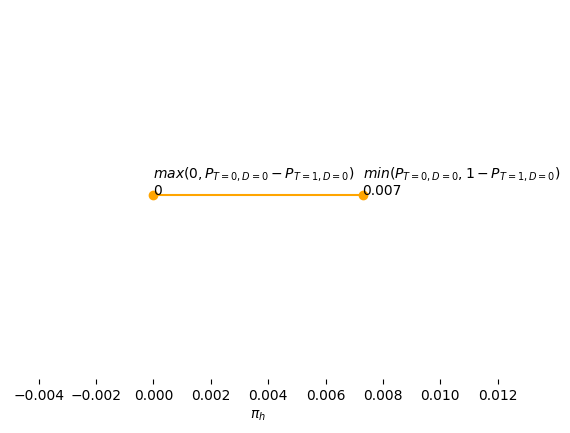

pi_h 0.0:
            LB: 1st intagral: -6.35 to -5.39. 2nd intagral: -8.172639647802304 to -7.17.
            UB: 1st intagral: -6.35 to -5.35. 2nd intagral: -8.172639647802304 to -7.17. 
            Zhang and Rubin bounds are [2.7173772640050318e-08, 3.7218651760156565e-08]
            
pi_h 0.001:
            LB: 1st intagral: -6.35 to -5.39. 2nd intagral: -8.172639647802304 to -7.17.
            UB: 1st intagral: -6.35 to -5.35. 2nd intagral: -8.172639647802304 to -7.17. 
            Zhang and Rubin bounds are [2.6970124953801962e-08, 3.7218654605391235e-08]
            
pi_h 0.002:
            LB: 1st intagral: -6.35 to -5.39. 2nd intagral: -8.172639647802304 to -7.17.
            UB: 1st intagral: -6.35 to -5.35. 2nd intagral: -8.172639647802304 to -7.17. 
            Zhang and Rubin bounds are [2.6767495716338552e-08, 3.721865743226084e-08]
            
pi_h 0.003:
            LB: 1st intagral: -6.35 to -5.4. 2nd intagral: -8.172639647802304 to -7.17.
            UB: 1st intagra

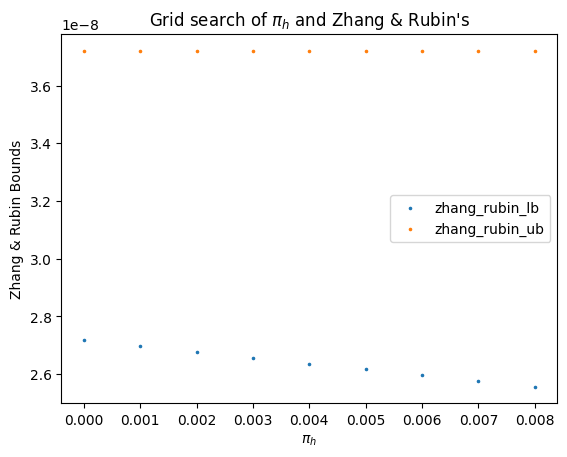

x is: -0.89


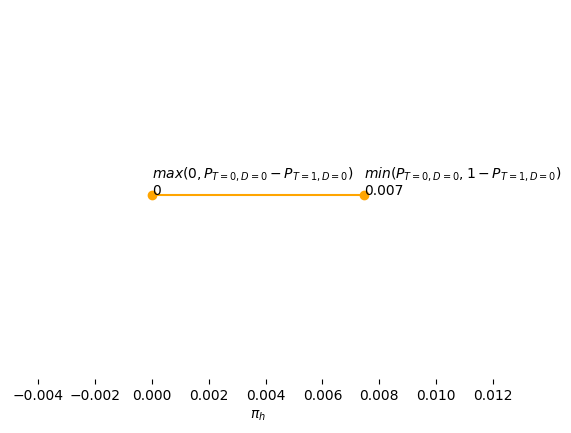

pi_h 0.0:
            LB: 1st intagral: -6.44 to -5.49. 2nd intagral: -8.219046555288125 to -7.22.
            UB: 1st intagral: -6.44 to -5.44. 2nd intagral: -8.219046555288125 to -7.22. 
            Zhang and Rubin bounds are [1.6074967250389483e-08, 2.2273233468475558e-08]
            
pi_h 0.001:
            LB: 1st intagral: -6.44 to -5.49. 2nd intagral: -8.219046555288125 to -7.22.
            UB: 1st intagral: -6.44 to -5.44. 2nd intagral: -8.219046555288125 to -7.22. 
            Zhang and Rubin bounds are [1.5952635551811442e-08, 2.2273235508699704e-08]
            
pi_h 0.002:
            LB: 1st intagral: -6.44 to -5.49. 2nd intagral: -8.219046555288125 to -7.22.
            UB: 1st intagral: -6.44 to -5.44. 2nd intagral: -8.219046555288125 to -7.22. 
            Zhang and Rubin bounds are [1.5830930084572496e-08, 2.2273237535641196e-08]
            
pi_h 0.003:
            LB: 1st intagral: -6.44 to -5.49. 2nd intagral: -8.219046555288125 to -7.22.
            UB: 1st intag

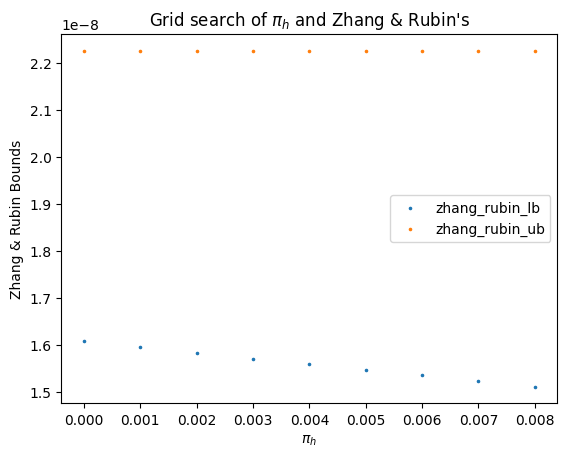

x is: -0.88


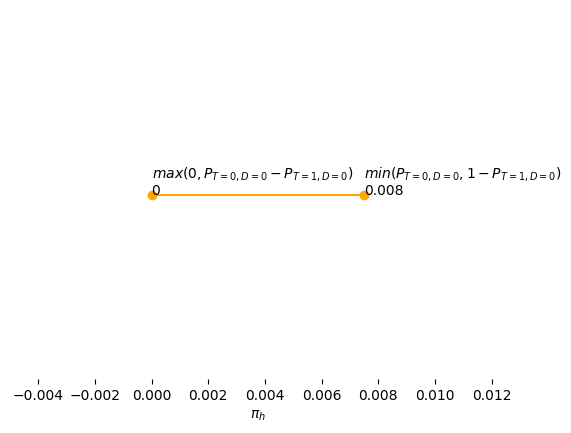

pi_h 0.0:
            LB: 1st intagral: -6.46 to -5.51. 2nd intagral: -8.232334448672798 to -7.23.
            UB: 1st intagral: -6.46 to -5.46. 2nd intagral: -8.232334448672798 to -7.23. 
            Zhang and Rubin bounds are [1.3808894466227259e-08, 1.9198176322775858e-08]
            
pi_h 0.001:
            LB: 1st intagral: -6.46 to -5.51. 2nd intagral: -8.232334448672798 to -7.23.
            UB: 1st intagral: -6.46 to -5.46. 2nd intagral: -8.232334448672798 to -7.23. 
            Zhang and Rubin bounds are [1.3703347150170332e-08, 1.9198178176947457e-08]
            
pi_h 0.002:
            LB: 1st intagral: -6.46 to -5.51. 2nd intagral: -8.232334448672798 to -7.23.
            UB: 1st intagral: -6.46 to -5.46. 2nd intagral: -8.232334448672798 to -7.23. 
            Zhang and Rubin bounds are [1.3598343750073396e-08, 1.9198180019017755e-08]
            
pi_h 0.003:
            LB: 1st intagral: -6.46 to -5.52. 2nd intagral: -8.232334448672798 to -7.23.
            UB: 1st intag

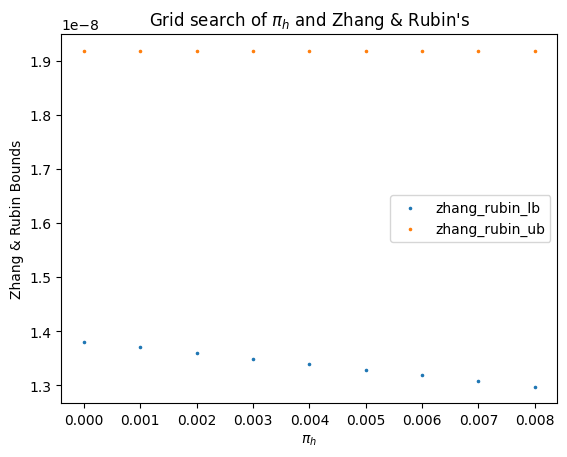

x is: -0.86


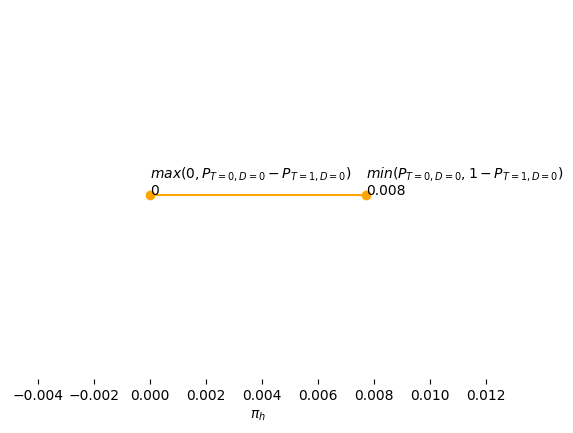

pi_h 0.0:
            LB: 1st intagral: -6.57 to -5.62. 2nd intagral: -8.284754593840916 to -7.28.
            UB: 1st intagral: -6.57 to -5.57. 2nd intagral: -8.284754593840916 to -7.28. 
            Zhang and Rubin bounds are [7.52926747416634e-09, 1.0611505238492094e-08]
            
pi_h 0.001:
            LB: 1st intagral: -6.57 to -5.62. 2nd intagral: -8.284754593840916 to -7.28.
            UB: 1st intagral: -6.57 to -5.57. 2nd intagral: -8.284754593840916 to -7.29. 
            Zhang and Rubin bounds are [7.47072076322524e-09, 1.061150650785741e-08]
            
pi_h 0.002:
            LB: 1st intagral: -6.57 to -5.62. 2nd intagral: -8.284754593840916 to -7.28.
            UB: 1st intagral: -6.57 to -5.57. 2nd intagral: -8.284754593840916 to -7.29. 
            Zhang and Rubin bounds are [7.412483672782215e-09, 1.0611507768857839e-08]
            
pi_h 0.003:
            LB: 1st intagral: -6.57 to -5.62. 2nd intagral: -8.284754593840916 to -7.28.
            UB: 1st intagral: -

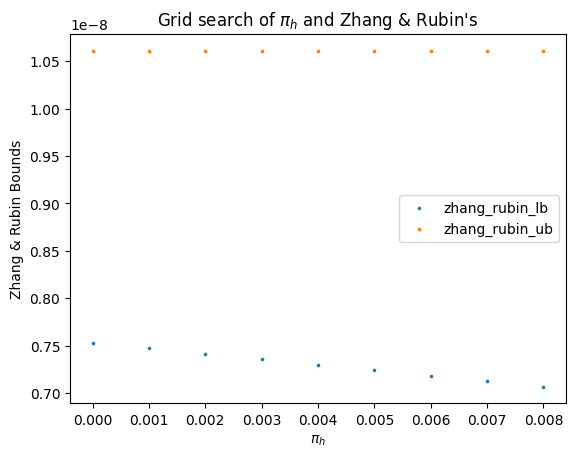

x is: -0.8


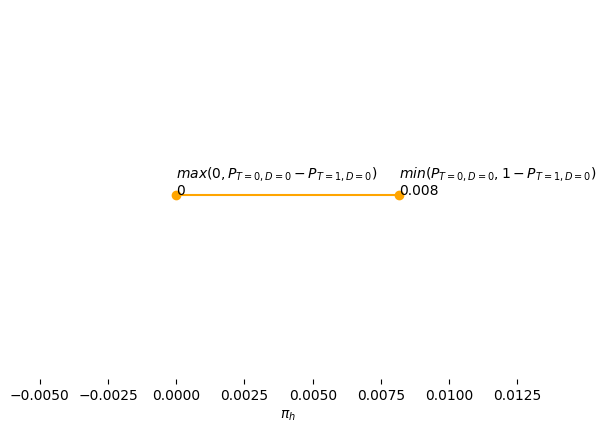

pi_h 0.0:
            LB: 1st intagral: -6.81 to -5.86. 2nd intagral: -8.404490704491161 to -7.4.
            UB: 1st intagral: -6.81 to -5.81. 2nd intagral: -8.404490704491161 to -7.4. 
            Zhang and Rubin bounds are [1.8057378511115175e-09, 2.6304662059040545e-09]
            
pi_h 0.001:
            LB: 1st intagral: -6.81 to -5.86. 2nd intagral: -8.404490704491161 to -7.4.
            UB: 1st intagral: -6.81 to -5.81. 2nd intagral: -8.404490704491161 to -7.41. 
            Zhang and Rubin bounds are [1.791140600071356e-09, 2.630466734699493e-09]
            
pi_h 0.002:
            LB: 1st intagral: -6.81 to -5.86. 2nd intagral: -8.404490704491161 to -7.4.
            UB: 1st intagral: -6.81 to -5.81. 2nd intagral: -8.404490704491161 to -7.41. 
            Zhang and Rubin bounds are [1.7766250996326658e-09, 2.630467259932841e-09]
            
pi_h 0.003:
            LB: 1st intagral: -6.81 to -5.86. 2nd intagral: -8.404490704491161 to -7.4.
            UB: 1st intagral: -6.

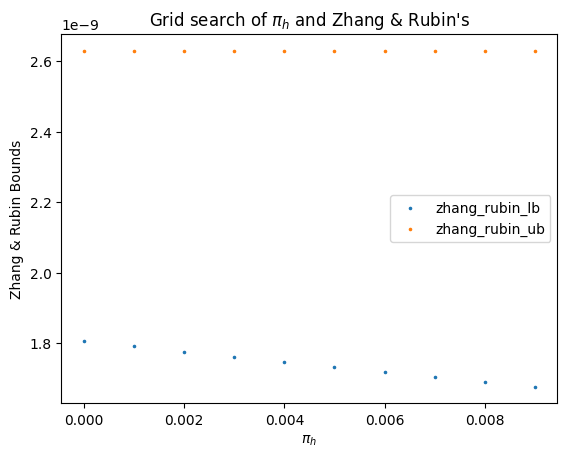

x is: -0.76


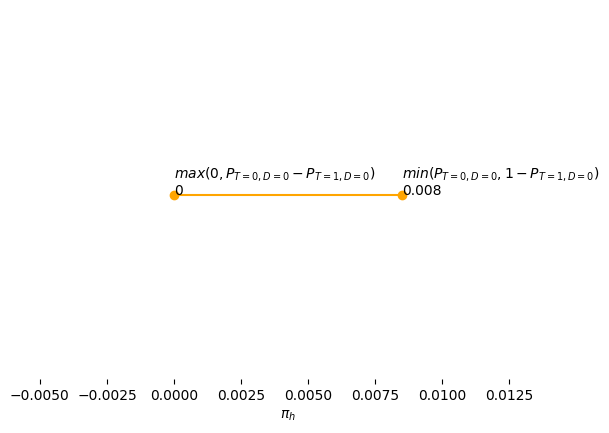

pi_h 0.0:
            LB: 1st intagral: -6.96 to -6.01. 2nd intagral: -8.479048527277005 to -7.48.
            UB: 1st intagral: -6.96 to -5.96. 2nd intagral: -8.479048527277005 to -7.48. 
            Zhang and Rubin bounds are [7.203361800069725e-10, 1.0726579129860566e-09]
            
pi_h 0.001:
            LB: 1st intagral: -6.96 to -6.01. 2nd intagral: -8.479048527277005 to -7.48.
            UB: 1st intagral: -6.96 to -5.96. 2nd intagral: -8.479048527277005 to -7.48. 
            Zhang and Rubin bounds are [7.14372134656727e-10, 1.072658217343712e-09]
            
pi_h 0.002:
            LB: 1st intagral: -6.96 to -6.01. 2nd intagral: -8.479048527277005 to -7.48.
            UB: 1st intagral: -6.96 to -5.96. 2nd intagral: -8.479048527277005 to -7.48. 
            Zhang and Rubin bounds are [7.084426708258326e-10, 1.072658519623061e-09]
            
pi_h 0.003:
            LB: 1st intagral: -6.96 to -6.02. 2nd intagral: -8.479048527277005 to -7.48.
            UB: 1st intagral: -

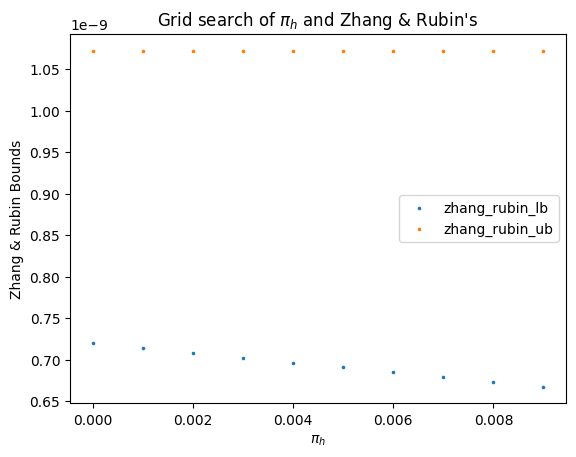

x is: -0.75


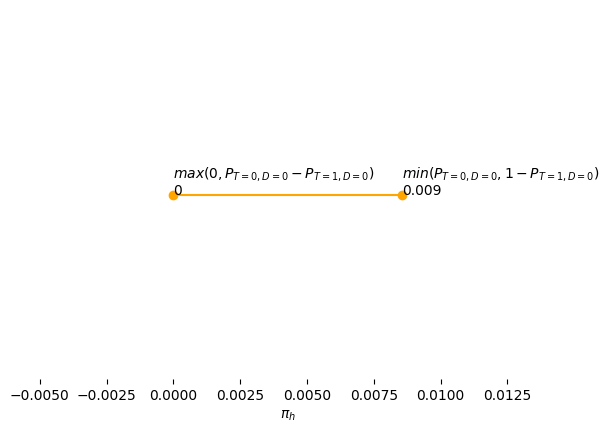

pi_h 0.0:
            LB: 1st intagral: -6.99 to -6.05. 2nd intagral: -8.497188893942178 to -7.5.
            UB: 1st intagral: -6.99 to -5.99. 2nd intagral: -8.497188893942178 to -7.5. 
            Zhang and Rubin bounds are [5.740037306700297e-10, 8.5948413701049e-10]
            
pi_h 0.001:
            LB: 1st intagral: -6.99 to -6.05. 2nd intagral: -8.497188893942178 to -7.5.
            UB: 1st intagral: -6.99 to -5.99. 2nd intagral: -8.497188893942178 to -7.5. 
            Zhang and Rubin bounds are [5.692236397268465e-10, 8.594844028716692e-10]
            
pi_h 0.002:
            LB: 1st intagral: -6.99 to -6.05. 2nd intagral: -8.497188893942178 to -7.5.
            UB: 1st intagral: -6.99 to -5.99. 2nd intagral: -8.497188893942178 to -7.5. 
            Zhang and Rubin bounds are [5.644714973430973e-10, 8.594846669114151e-10]
            
pi_h 0.003:
            LB: 1st intagral: -6.99 to -6.05. 2nd intagral: -8.497188893942178 to -7.5.
            UB: 1st intagral: -6.99 to -

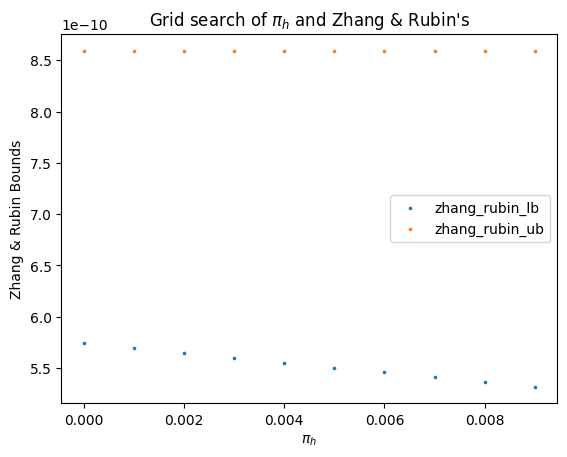

x is: -0.72


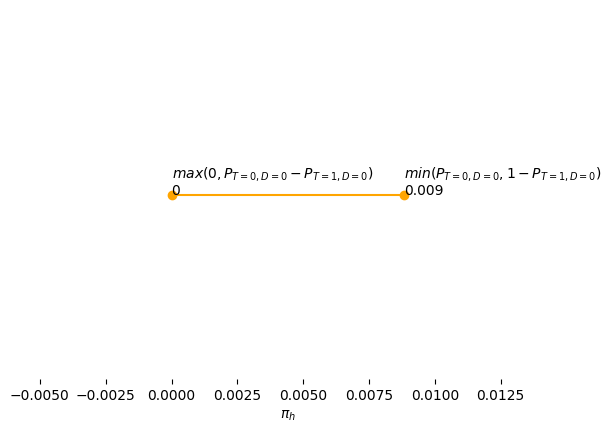

pi_h 0.0:
            LB: 1st intagral: -7.12 to -6.18. 2nd intagral: -8.560336060946096 to -7.56.
            UB: 1st intagral: -7.12 to -6.12. 2nd intagral: -8.560336060946096 to -7.56. 
            Zhang and Rubin bounds are [2.5762495611993134e-10, 3.934497307714707e-10]
            
pi_h 0.001:
            LB: 1st intagral: -7.12 to -6.18. 2nd intagral: -8.560336060946096 to -7.56.
            UB: 1st intagral: -7.12 to -6.12. 2nd intagral: -8.560336060946096 to -7.56. 
            Zhang and Rubin bounds are [2.55436023127806e-10, 3.934498963941802e-10]
            
pi_h 0.002:
            LB: 1st intagral: -7.12 to -6.18. 2nd intagral: -8.560336060946096 to -7.56.
            UB: 1st intagral: -7.12 to -6.12. 2nd intagral: -8.560336060946096 to -7.56. 
            Zhang and Rubin bounds are [2.5326026108955727e-10, 3.934500608691216e-10]
            
pi_h 0.003:
            LB: 1st intagral: -7.12 to -6.18. 2nd intagral: -8.560336060946096 to -7.56.
            UB: 1st intagral: 

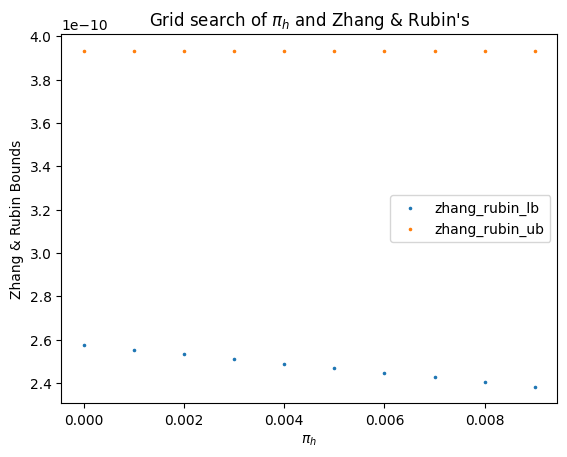

x is: -0.7


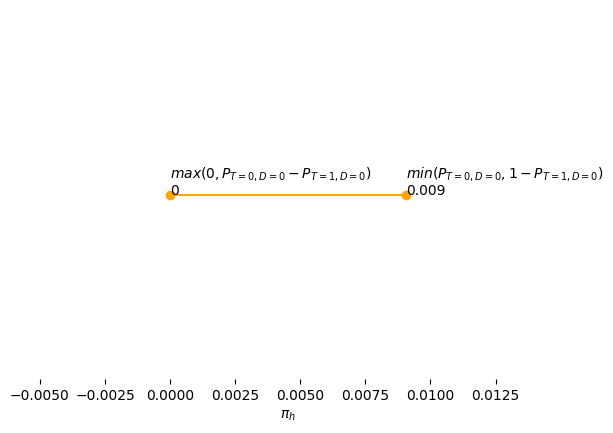

pi_h 0.0:
            LB: 1st intagral: -7.22 to -6.27. 2nd intagral: -8.607610774049178 to -7.61.
            UB: 1st intagral: -7.22 to -6.22. 2nd intagral: -8.607610774049178 to -7.61. 
            Zhang and Rubin bounds are [1.398950840054396e-10, 2.1695518249760468e-10]
            
pi_h 0.001:
            LB: 1st intagral: -7.22 to -6.27. 2nd intagral: -8.607610774049178 to -7.61.
            UB: 1st intagral: -7.22 to -6.22. 2nd intagral: -8.607610774049178 to -7.61. 
            Zhang and Rubin bounds are [1.3868853508194985e-10, 2.169552984107442e-10]
            
pi_h 0.002:
            LB: 1st intagral: -7.22 to -6.28. 2nd intagral: -8.607610774049178 to -7.61.
            UB: 1st intagral: -7.22 to -6.22. 2nd intagral: -8.607610774049178 to -7.61. 
            Zhang and Rubin bounds are [1.374894014250361e-10, 2.1695541351370131e-10]
            
pi_h 0.003:
            LB: 1st intagral: -7.22 to -6.28. 2nd intagral: -8.607610774049178 to -7.61.
            UB: 1st intagral

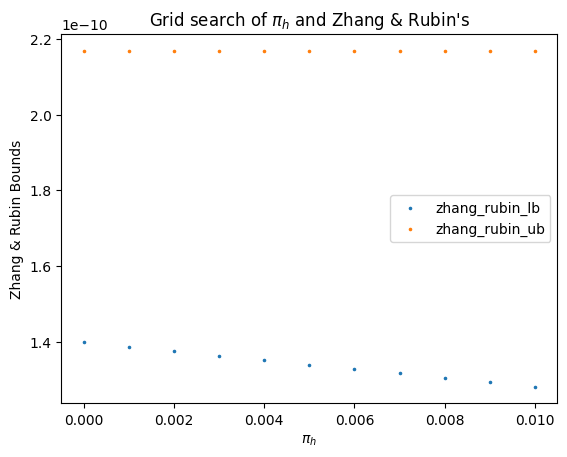

x is: -0.69


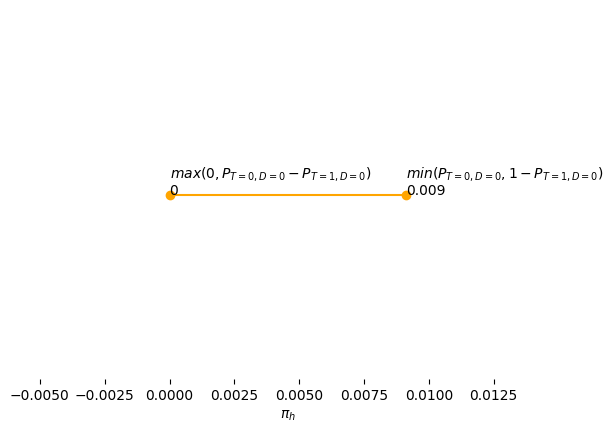

pi_h 0.0:
            LB: 1st intagral: -7.25 to -6.31. 2nd intagral: -8.625748170684345 to -7.63.
            UB: 1st intagral: -7.25 to -6.25. 2nd intagral: -8.625748170684345 to -7.63. 
            Zhang and Rubin bounds are [1.1040496501436663e-10, 1.7225459769823436e-10]
            
pi_h 0.001:
            LB: 1st intagral: -7.25 to -6.31. 2nd intagral: -8.625748170684345 to -7.63.
            UB: 1st intagral: -7.25 to -6.25. 2nd intagral: -8.625748170684345 to -7.63. 
            Zhang and Rubin bounds are [1.0944729194352226e-10, 1.7225469872049032e-10]
            
pi_h 0.002:
            LB: 1st intagral: -7.25 to -6.31. 2nd intagral: -8.625748170684345 to -7.63.
            UB: 1st intagral: -7.25 to -6.25. 2nd intagral: -8.625748170684345 to -7.63. 
            Zhang and Rubin bounds are [1.0849555250922336e-10, 1.7225479903432452e-10]
            
pi_h 0.003:
            LB: 1st intagral: -7.25 to -6.31. 2nd intagral: -8.625748170684345 to -7.63.
            UB: 1st intag

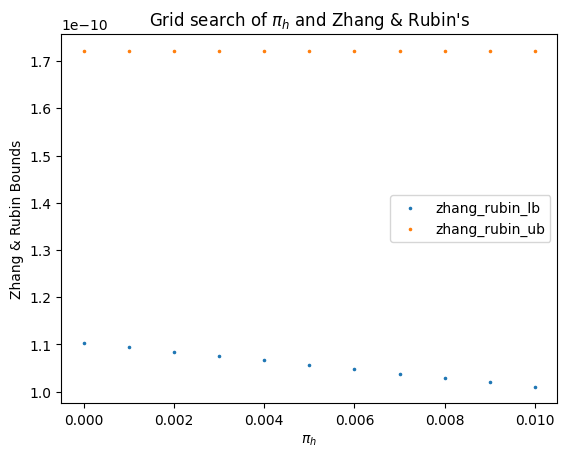

x is: -0.66
** including the non parametric bounds **


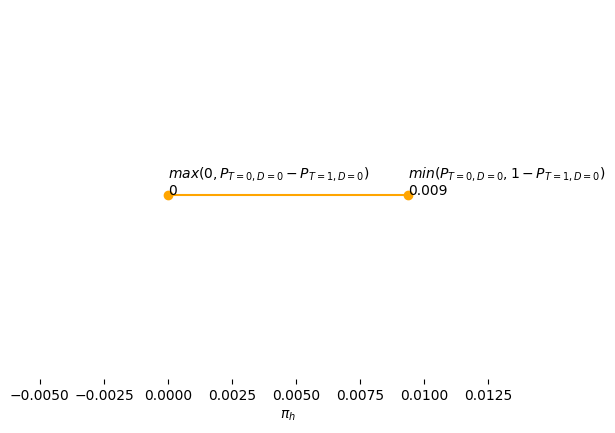

pi_h 0.0:
            LB: 1st intagral: -7.35 to -6.41. 2nd intagral: -8.675740252288659 to -7.68.
            UB: 1st intagral: -7.35 to -6.35. 2nd intagral: -8.675740252288659 to -7.68. 
            Zhang and Rubin bounds are [5.708443734333012e-11, 9.058883954111897e-11]
            
pi_h 0.001:
            LB: 1st intagral: -7.35 to -6.41. 2nd intagral: -8.675740252288659 to -7.68.
            UB: 1st intagral: -7.35 to -6.35. 2nd intagral: -8.675740252288659 to -7.68. 
            Zhang and Rubin bounds are [5.6581422469702304e-11, 9.058890858037905e-11]
            
pi_h 0.002:
            LB: 1st intagral: -7.35 to -6.41. 2nd intagral: -8.675740252288659 to -7.68.
            UB: 1st intagral: -7.35 to -6.35. 2nd intagral: -8.675740252288659 to -7.68. 
            Zhang and Rubin bounds are [5.6081593421019206e-11, 9.058897713111284e-11]
            
pi_h 0.003:
            LB: 1st intagral: -7.35 to -6.41. 2nd intagral: -8.675740252288659 to -7.68.
            UB: 1st intagral:

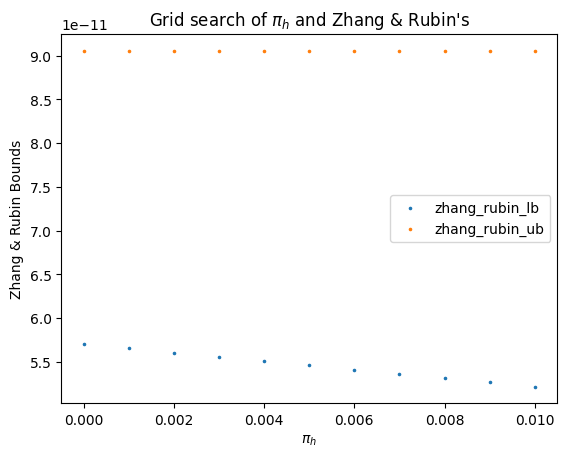

x is: -0.64


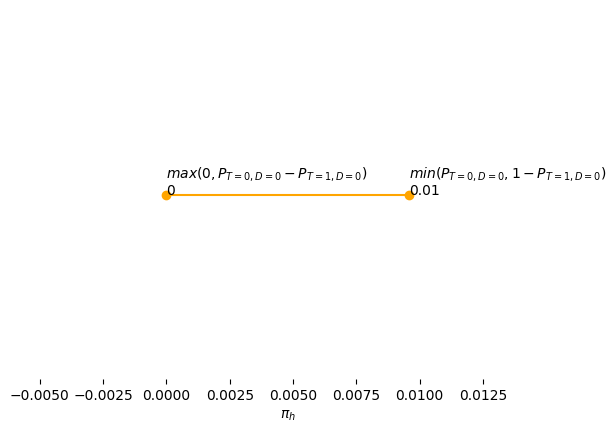

pi_h 0.0:
            LB: 1st intagral: -7.45 to -6.51. 2nd intagral: -8.724932264662641 to -7.72.
            UB: 1st intagral: -7.45 to -6.45. 2nd intagral: -8.724932264662641 to -7.72. 
            Zhang and Rubin bounds are [2.9525960917870085e-11, 4.767215467904698e-11]
            
pi_h 0.001:
            LB: 1st intagral: -7.45 to -6.51. 2nd intagral: -8.724932264662641 to -7.72.
            UB: 1st intagral: -7.45 to -6.45. 2nd intagral: -8.724932264662641 to -7.73. 
            Zhang and Rubin bounds are [2.9261738919106563e-11, 4.76722020355926e-11]
            
pi_h 0.002:
            LB: 1st intagral: -7.45 to -6.51. 2nd intagral: -8.724932264662641 to -7.72.
            UB: 1st intagral: -7.45 to -6.45. 2nd intagral: -8.724932264662641 to -7.73. 
            Zhang and Rubin bounds are [2.899922663725202e-11, 4.767224905405843e-11]
            
pi_h 0.003:
            LB: 1st intagral: -7.45 to -6.51. 2nd intagral: -8.724932264662641 to -7.72.
            UB: 1st intagral: 

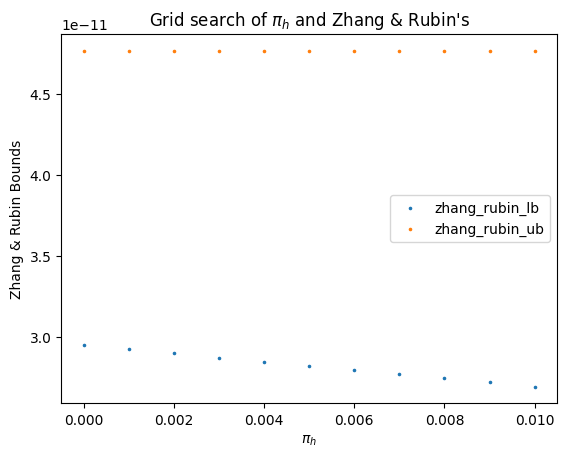

x is: -0.63


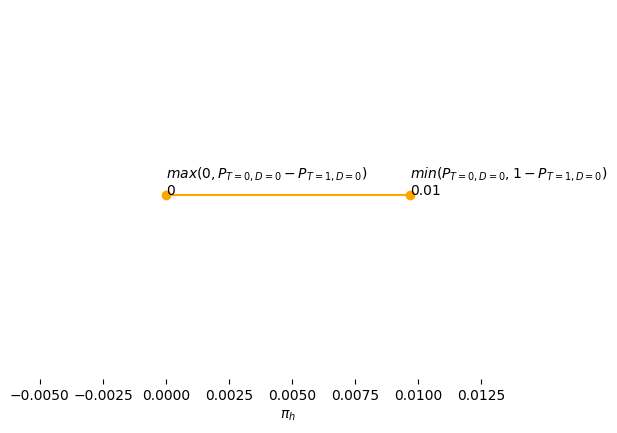

pi_h 0.0:
            LB: 1st intagral: -7.48 to -6.54. 2nd intagral: -8.739417822102109 to -7.74.
            UB: 1st intagral: -7.48 to -6.48. 2nd intagral: -8.739417822102109 to -7.74. 
            Zhang and Rubin bounds are [2.4269163213956727e-11, 3.938883083503329e-11]
            
pi_h 0.001:
            LB: 1st intagral: -7.48 to -6.54. 2nd intagral: -8.739417822102109 to -7.74.
            UB: 1st intagral: -7.48 to -6.48. 2nd intagral: -8.739417822102109 to -7.74. 
            Zhang and Rubin bounds are [2.4050996144134225e-11, 3.938887319677821e-11]
            
pi_h 0.002:
            LB: 1st intagral: -7.48 to -6.54. 2nd intagral: -8.739417822102109 to -7.74.
            UB: 1st intagral: -7.48 to -6.48. 2nd intagral: -8.739417822102109 to -7.74. 
            Zhang and Rubin bounds are [2.3834249576166375e-11, 3.93889152553127e-11]
            
pi_h 0.003:
            LB: 1st intagral: -7.48 to -6.54. 2nd intagral: -8.739417822102109 to -7.74.
            UB: 1st intagral:

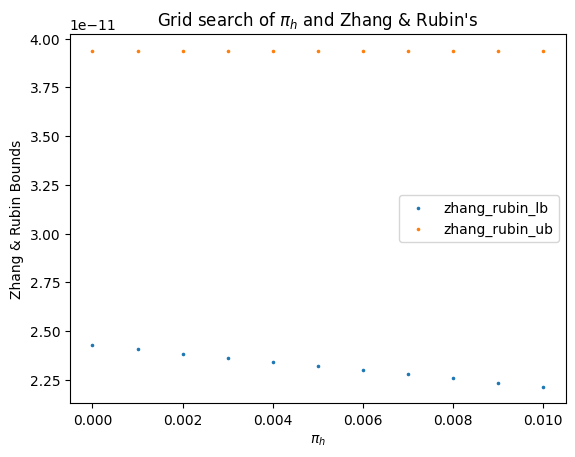

x is: -0.62


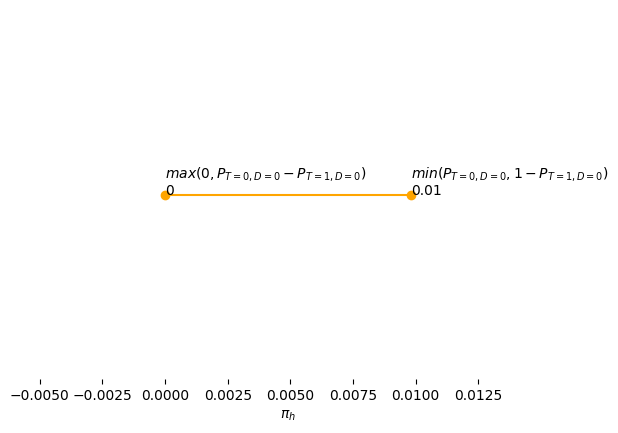

pi_h 0.0:
            LB: 1st intagral: -7.54 to -6.6. 2nd intagral: -8.769156075234683 to -7.77.
            UB: 1st intagral: -7.54 to -6.54. 2nd intagral: -8.769156075234683 to -7.77. 
            Zhang and Rubin bounds are [1.6182644851258193e-11, 2.6550471586514425e-11]
            
pi_h 0.001:
            LB: 1st intagral: -7.54 to -6.6. 2nd intagral: -8.769156075234683 to -7.77.
            UB: 1st intagral: -7.54 to -6.54. 2nd intagral: -8.769156075234683 to -7.77. 
            Zhang and Rubin bounds are [1.6035812290351843e-11, 2.6550505262283617e-11]
            
pi_h 0.002:
            LB: 1st intagral: -7.54 to -6.6. 2nd intagral: -8.769156075234683 to -7.77.
            UB: 1st intagral: -7.54 to -6.54. 2nd intagral: -8.769156075234683 to -7.77. 
            Zhang and Rubin bounds are [1.588994809144831e-11, 2.65505386957216e-11]
            
pi_h 0.003:
            LB: 1st intagral: -7.54 to -6.6. 2nd intagral: -8.769156075234683 to -7.77.
            UB: 1st intagral: -7

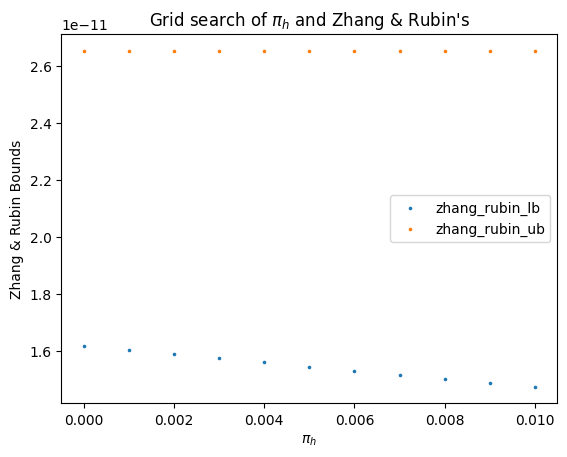

x is: -0.61


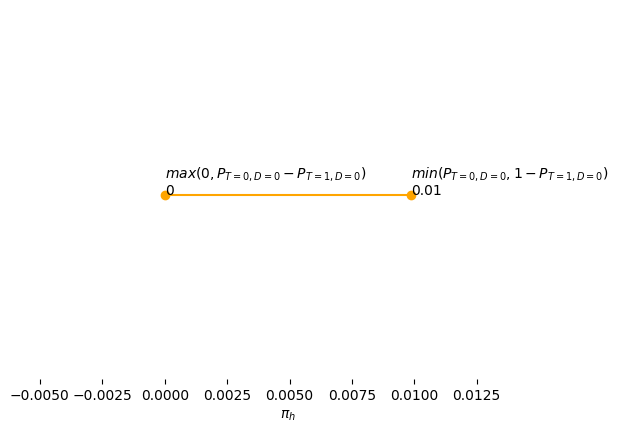

pi_h 0.0:
            LB: 1st intagral: -7.57 to -6.63. 2nd intagral: -8.783164539157186 to -7.78.
            UB: 1st intagral: -7.57 to -6.57. 2nd intagral: -8.783164539157186 to -7.78. 
            Zhang and Rubin bounds are [1.3353100932876332e-11, 2.2021855692759747e-11]
            
pi_h 0.001:
            LB: 1st intagral: -7.57 to -6.63. 2nd intagral: -8.783164539157186 to -7.78.
            UB: 1st intagral: -7.57 to -6.57. 2nd intagral: -8.783164539157186 to -7.78. 
            Zhang and Rubin bounds are [1.3231410811350625e-11, 2.2021885909171664e-11]
            
pi_h 0.002:
            LB: 1st intagral: -7.57 to -6.63. 2nd intagral: -8.783164539157186 to -7.78.
            UB: 1st intagral: -7.57 to -6.57. 2nd intagral: -8.783164539157186 to -7.79. 
            Zhang and Rubin bounds are [1.3110528088498585e-11, 2.202191590759816e-11]
            
pi_h 0.003:
            LB: 1st intagral: -7.57 to -6.63. 2nd intagral: -8.783164539157186 to -7.78.
            UB: 1st intagr

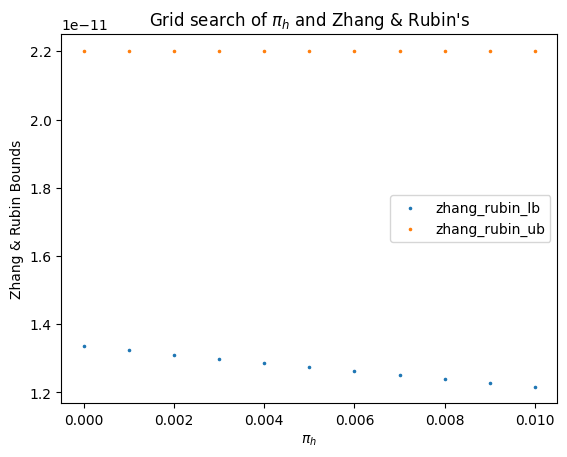

x is: -0.54


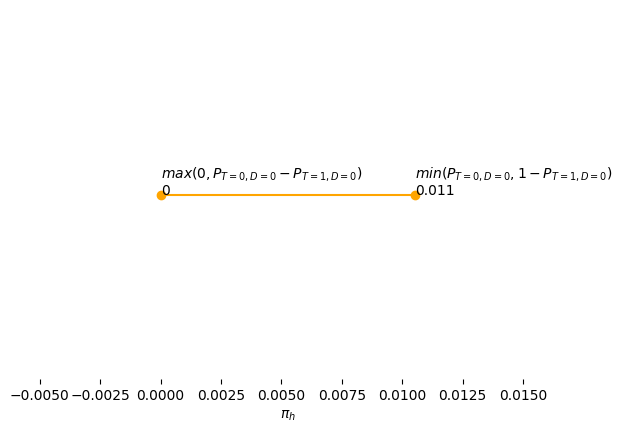

pi_h 0.0:
            LB: 1st intagral: -7.83 to -6.9. 2nd intagral: -8.91519266196649 to -7.92.
            UB: 1st intagral: -7.83 to -6.83. 2nd intagral: -8.91519266196649 to -7.92. 
            Zhang and Rubin bounds are [2.095457267515372e-12, 3.6377379806272635e-12]
            
pi_h 0.001:
            LB: 1st intagral: -7.83 to -6.9. 2nd intagral: -8.91519266196649 to -7.92.
            UB: 1st intagral: -7.83 to -6.83. 2nd intagral: -8.91519266196649 to -7.92. 
            Zhang and Rubin bounds are [2.075558690828407e-12, 3.6377487567180895e-12]
            
pi_h 0.002:
            LB: 1st intagral: -7.83 to -6.9. 2nd intagral: -8.91519266196649 to -7.92.
            UB: 1st intagral: -7.83 to -6.83. 2nd intagral: -8.91519266196649 to -7.92. 
            Zhang and Rubin bounds are [2.055799682812088e-12, 3.637759453207705e-12]
            
pi_h 0.003:
            LB: 1st intagral: -7.83 to -6.9. 2nd intagral: -8.91519266196649 to -7.92.
            UB: 1st intagral: -7.83 to -

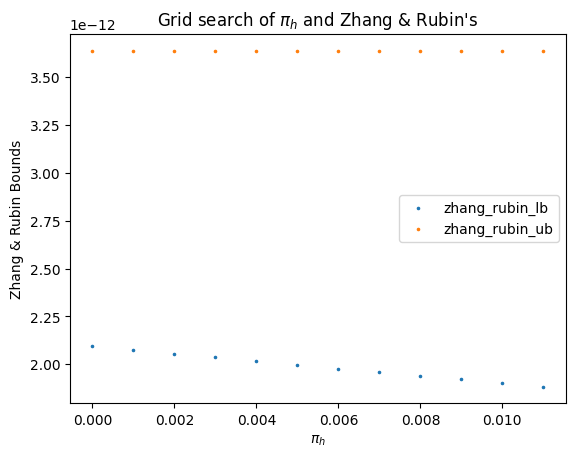

x is: -0.54


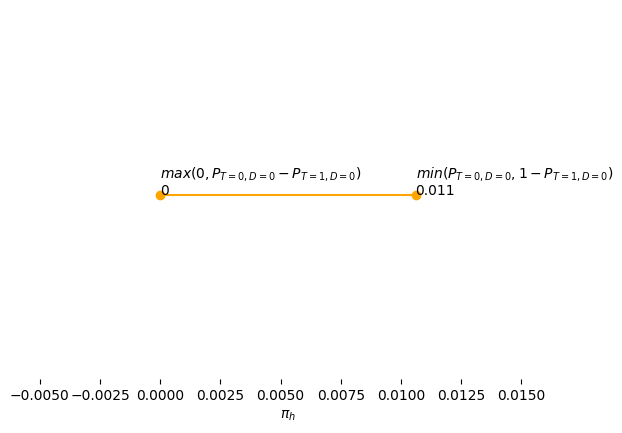

pi_h 0.0:
            LB: 1st intagral: -7.86 to -6.93. 2nd intagral: -8.928850780587268 to -7.93.
            UB: 1st intagral: -7.86 to -6.86. 2nd intagral: -8.928850780587268 to -7.93. 
            Zhang and Rubin bounds are [1.722854573806207e-12, 3.007618996026236e-12]
            
pi_h 0.001:
            LB: 1st intagral: -7.86 to -6.93. 2nd intagral: -8.928850780587268 to -7.93.
            UB: 1st intagral: -7.86 to -6.86. 2nd intagral: -8.928850780587268 to -7.93. 
            Zhang and Rubin bounds are [1.7064245029299734e-12, 3.007628672453635e-12]
            
pi_h 0.002:
            LB: 1st intagral: -7.86 to -6.93. 2nd intagral: -8.928850780587268 to -7.93.
            UB: 1st intagral: -7.86 to -6.86. 2nd intagral: -8.928850780587268 to -7.93. 
            Zhang and Rubin bounds are [1.69011032460786e-12, 3.0076382772280733e-12]
            
pi_h 0.003:
            LB: 1st intagral: -7.86 to -6.93. 2nd intagral: -8.928850780587268 to -7.93.
            UB: 1st intagral: 

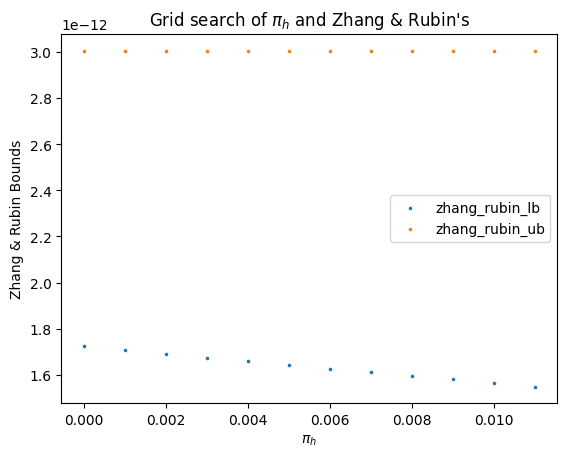

x is: -0.48


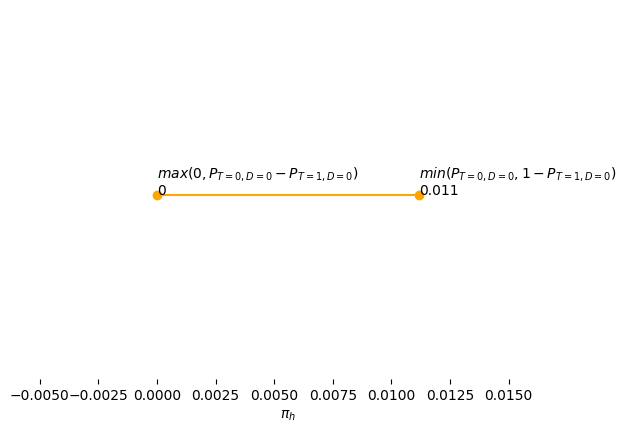

pi_h 0.0:
            LB: 1st intagral: -8.06 to -7.13. 2nd intagral: -9.03155074173281 to -8.03.
            UB: 1st intagral: -8.06 to -7.06. 2nd intagral: -9.03155074173281 to -8.03. 
            Zhang and Rubin bounds are [3.853322926693503e-13, 7.027054432681168e-13]
            
pi_h 0.001:
            LB: 1st intagral: -8.06 to -7.14. 2nd intagral: -9.03155074173281 to -8.03.
            UB: 1st intagral: -8.06 to -7.06. 2nd intagral: -9.03155074173281 to -8.03. 
            Zhang and Rubin bounds are [3.8153777761322535e-13, 7.027097255094899e-13]
            
pi_h 0.002:
            LB: 1st intagral: -8.06 to -7.14. 2nd intagral: -9.03155074173281 to -8.03.
            UB: 1st intagral: -8.06 to -7.06. 2nd intagral: -9.03155074173281 to -8.03. 
            Zhang and Rubin bounds are [3.7777117989631054e-13, 7.027139754542398e-13]
            
pi_h 0.003:
            LB: 1st intagral: -8.06 to -7.14. 2nd intagral: -9.03155074173281 to -8.03.
            UB: 1st intagral: -8.06 

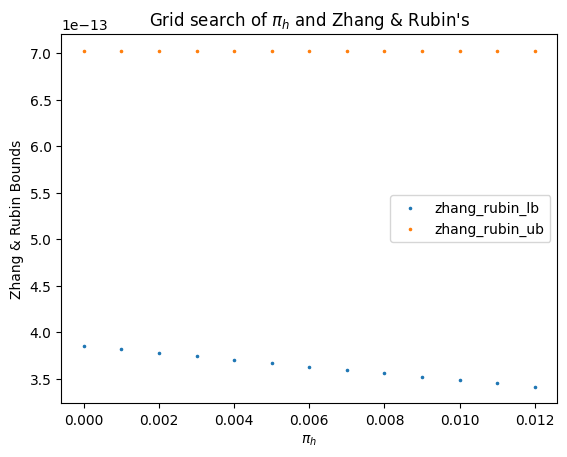

x is: -0.38


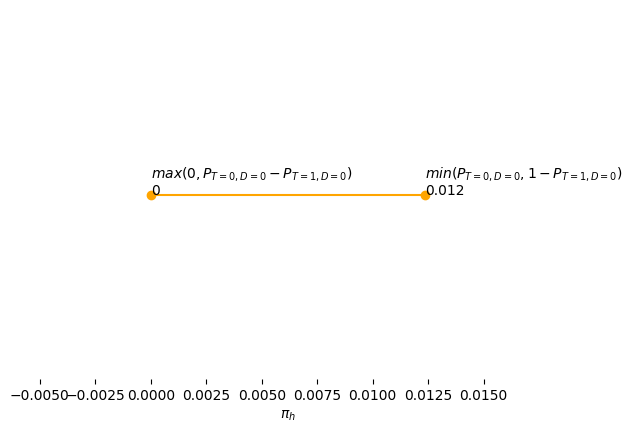

/Users/hadarrosenwald/Downloads/technion/thesis/competing_risks_simulation/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  


pi_h 0.0:
            LB: 1st intagral: nan to nan. 2nd intagral: 0.761889534854689 to 1.76.
            UB: 1st intagral: nan to nan. 2nd intagral: 0.761889534854689 to 1.76. 
            Zhang and Rubin bounds are [nan, nan]
            
pi_h 0.001:
            LB: 1st intagral: nan to nan. 2nd intagral: 0.761889534854689 to 1.76.
            UB: 1st intagral: nan to nan. 2nd intagral: 0.761889534854689 to 1.76. 
            Zhang and Rubin bounds are [nan, nan]
            
pi_h 0.002:
            LB: 1st intagral: nan to nan. 2nd intagral: 0.761889534854689 to 1.76.
            UB: 1st intagral: nan to nan. 2nd intagral: 0.761889534854689 to 1.76. 
            Zhang and Rubin bounds are [nan, nan]
            
pi_h 0.003:
            LB: 1st intagral: nan to nan. 2nd intagral: 0.761889534854689 to 1.76.
            UB: 1st intagral: nan to nan. 2nd intagral: 0.761889534854689 to 1.76. 
            Zhang and Rubin bounds are [nan, nan]
            
pi_h 0.004:
            LB: 1st in

/Users/hadarrosenwald/Downloads/technion/thesis/competing_risks_simulation/venv/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: All-NaN axis encountered
/Users/hadarrosenwald/Downloads/technion/thesis/competing_risks_simulation/venv/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: All-NaN axis encountered


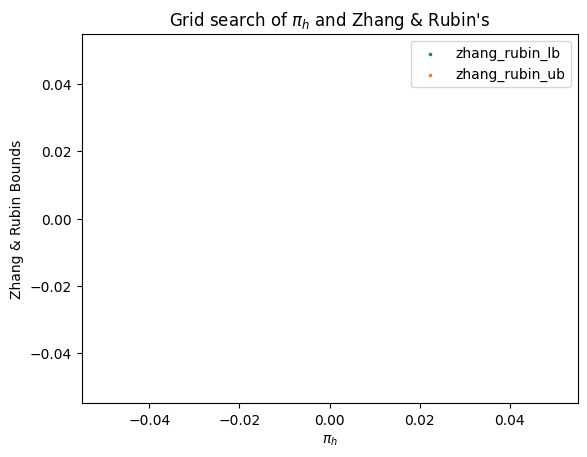

x is: -0.36


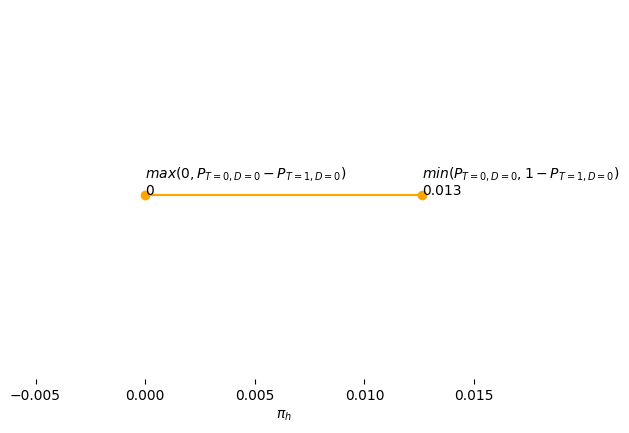

pi_h 0.0:
            LB: 1st intagral: -8.56 to -7.64. 2nd intagral: -9.280198404122448 to -8.28.
            UB: 1st intagral: -8.56 to -7.56. 2nd intagral: -9.280198404122448 to -8.28. 
            Zhang and Rubin bounds are [8.487704758499907e-15, 1.7466672178655383e-14]
            
pi_h 0.001:
            LB: 1st intagral: -8.56 to -7.64. 2nd intagral: -9.280198404122448 to -8.28.
            UB: 1st intagral: -8.56 to -7.56. 2nd intagral: -9.280198404122448 to -8.28. 
            Zhang and Rubin bounds are [8.397062920985249e-15, 1.7467242235169386e-14]
            
pi_h 0.002:
            LB: 1st intagral: -8.56 to -7.64. 2nd intagral: -9.280198404122448 to -8.28.
            UB: 1st intagral: -8.56 to -7.56. 2nd intagral: -9.280198404122448 to -8.28. 
            Zhang and Rubin bounds are [8.307157469722143e-15, 1.746780779746547e-14]
            
pi_h 0.003:
            LB: 1st intagral: -8.56 to -7.64. 2nd intagral: -9.280198404122448 to -8.28.
            UB: 1st intagral:

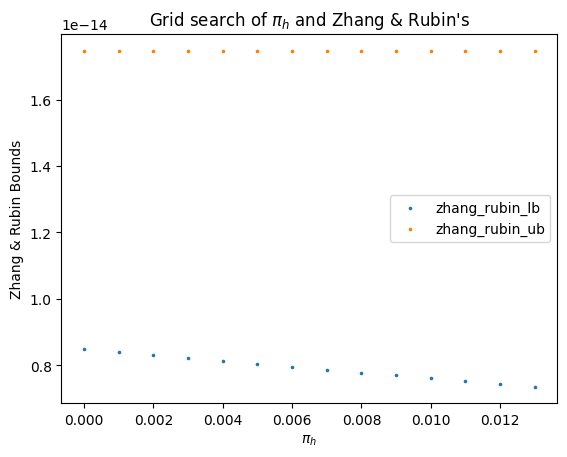

x is: -0.33


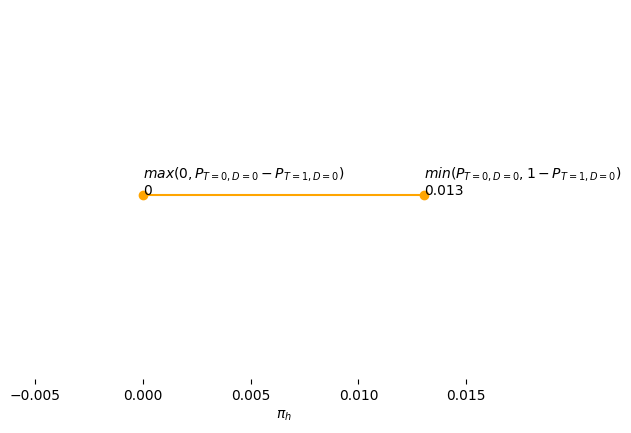

pi_h 0.0:
            LB: 1st intagral: -8.69 to -7.78. 2nd intagral: -9.346417112775683 to -8.35.
            UB: 1st intagral: -8.69 to -7.69. 2nd intagral: -9.346417112775683 to -8.35. 
            Zhang and Rubin bounds are [2.9303821794451745e-15, 6.258535422598629e-15]
            
pi_h 0.001:
            LB: 1st intagral: -8.69 to -7.78. 2nd intagral: -9.346417112775683 to -8.35.
            UB: 1st intagral: -8.69 to -7.69. 2nd intagral: -9.346417112775683 to -8.35. 
            Zhang and Rubin bounds are [2.898318759928711e-15, 6.258865232704507e-15]
            
pi_h 0.002:
            LB: 1st intagral: -8.69 to -7.78. 2nd intagral: -9.346417112775683 to -8.35.
            UB: 1st intagral: -8.69 to -7.69. 2nd intagral: -9.346417112775683 to -8.35. 
            Zhang and Rubin bounds are [2.8665226429316183e-15, 6.259192411782807e-15]
            
pi_h 0.003:
            LB: 1st intagral: -8.69 to -7.78. 2nd intagral: -9.346417112775683 to -8.35.
            UB: 1st intagral:

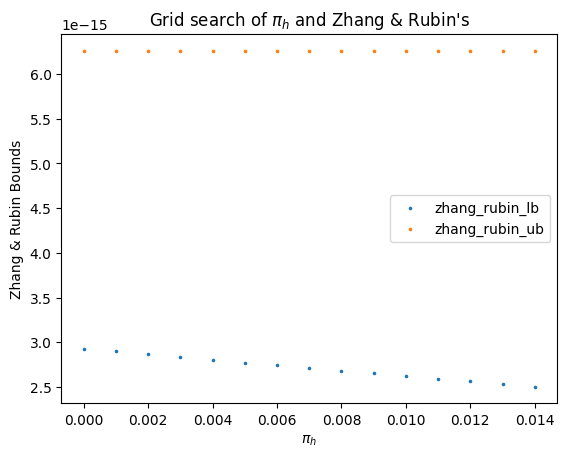

x is: -0.32


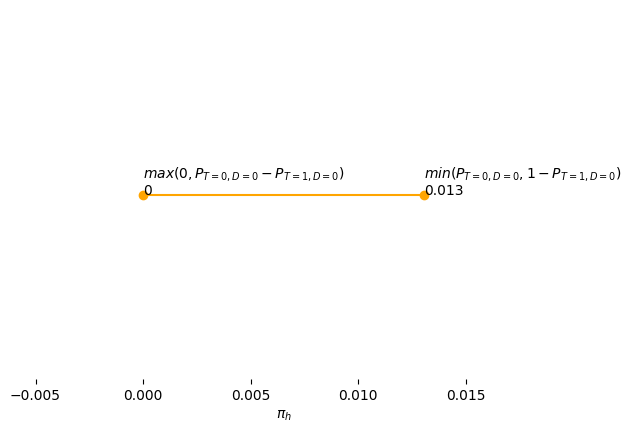

pi_h 0.0:
            LB: 1st intagral: -8.7 to -7.78. 2nd intagral: -9.350460685614511 to -8.35.
            UB: 1st intagral: -8.7 to -7.7. 2nd intagral: -9.350460685614511 to -8.35. 
            Zhang and Rubin bounds are [2.744231557026801e-15, 5.874838637308489e-15]
            
pi_h 0.001:
            LB: 1st intagral: -8.7 to -7.79. 2nd intagral: -9.350460685614511 to -8.35.
            UB: 1st intagral: -8.7 to -7.7. 2nd intagral: -9.350460685614511 to -8.35. 
            Zhang and Rubin bounds are [2.714157984553364e-15, 5.87515756454795e-15]
            
pi_h 0.002:
            LB: 1st intagral: -8.7 to -7.79. 2nd intagral: -9.350460685614511 to -8.35.
            UB: 1st intagral: -8.7 to -7.7. 2nd intagral: -9.350460685614511 to -8.35. 
            Zhang and Rubin bounds are [2.6843355240118166e-15, 5.875473945740986e-15]
            
pi_h 0.003:
            LB: 1st intagral: -8.7 to -7.79. 2nd intagral: -9.350460685614511 to -8.35.
            UB: 1st intagral: -8.7 to -7.

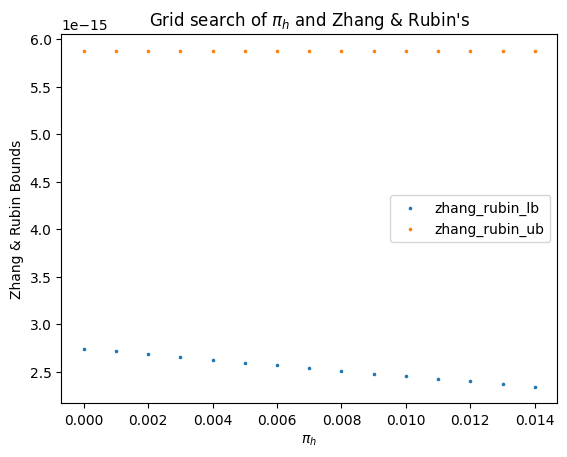

x is: -0.28


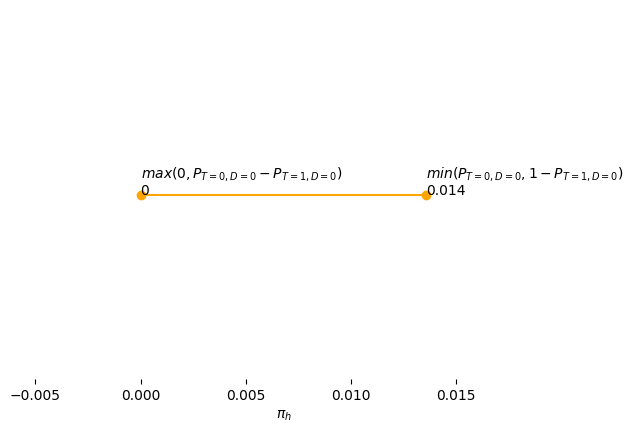

pi_h 0.0:
            LB: 1st intagral: 1.13 to 2.05. 2nd intagral: nan to nan.
            UB: 1st intagral: 1.13 to 2.13. 2nd intagral: nan to nan. 
            Zhang and Rubin bounds are [nan, nan]
            
pi_h 0.001:
            LB: 1st intagral: 1.13 to 2.04. 2nd intagral: nan to nan.
            UB: 1st intagral: 1.13 to 2.13. 2nd intagral: nan to nan. 
            Zhang and Rubin bounds are [nan, nan]
            
pi_h 0.002:
            LB: 1st intagral: 1.13 to 2.04. 2nd intagral: nan to nan.
            UB: 1st intagral: 1.13 to 2.13. 2nd intagral: nan to nan. 
            Zhang and Rubin bounds are [nan, nan]
            
pi_h 0.003:
            LB: 1st intagral: 1.13 to 2.04. 2nd intagral: nan to nan.
            UB: 1st intagral: 1.13 to 2.13. 2nd intagral: nan to nan. 
            Zhang and Rubin bounds are [nan, nan]
            
pi_h 0.004:
            LB: 1st intagral: 1.13 to 2.04. 2nd intagral: nan to nan.
            UB: 1st intagral: 1.13 to 2.13. 2nd intagral

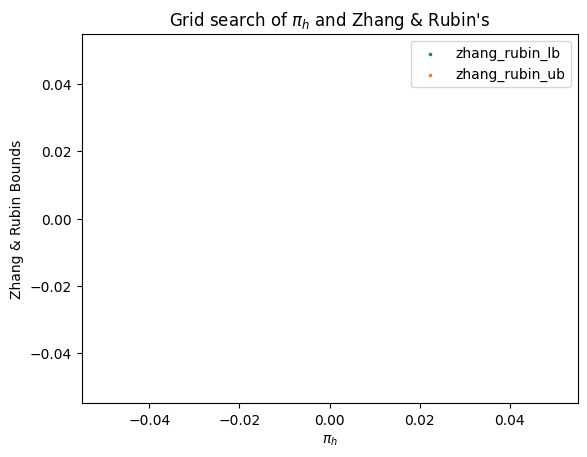

x is: -0.15


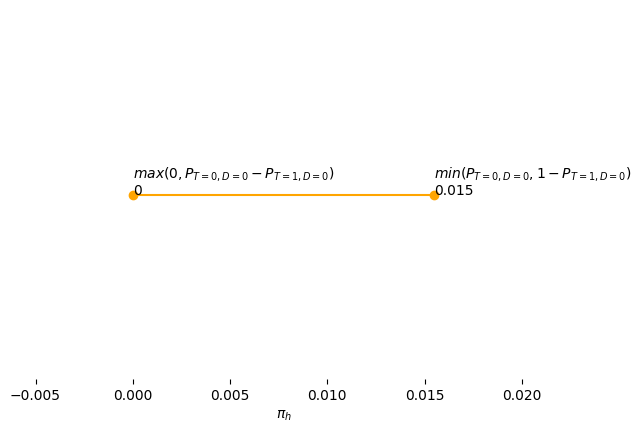

pi_h 0.0:
            LB: 1st intagral: -9.39 to -8.49. 2nd intagral: -9.696888036987906 to -8.7.
            UB: 1st intagral: -9.39 to -8.39. 2nd intagral: -9.696888036987906 to -8.7. 
            Zhang and Rubin bounds are [6.417867225365416e-18, 1.929477908940115e-17]
            
pi_h 0.001:
            LB: 1st intagral: -9.39 to -8.49. 2nd intagral: -9.696888036987906 to -8.7.
            UB: 1st intagral: -9.39 to -8.39. 2nd intagral: -9.696888036987906 to -8.7. 
            Zhang and Rubin bounds are [6.3223480594293605e-18, 1.931174233907176e-17]
            
pi_h 0.002:
            LB: 1st intagral: -9.39 to -8.5. 2nd intagral: -9.696888036987906 to -8.7.
            UB: 1st intagral: -9.39 to -8.39. 2nd intagral: -9.696888036987906 to -8.7. 
            Zhang and Rubin bounds are [6.2277391777659445e-18, 1.9328561512767378e-17]
            
pi_h 0.003:
            LB: 1st intagral: -9.39 to -8.5. 2nd intagral: -9.696888036987906 to -8.7.
            UB: 1st intagral: -9.39 t

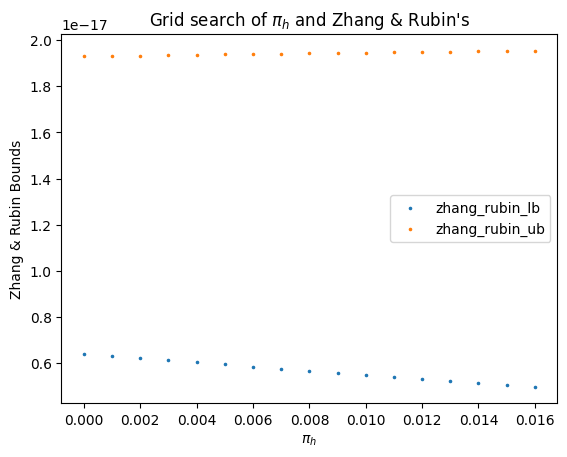

x is: -0.07


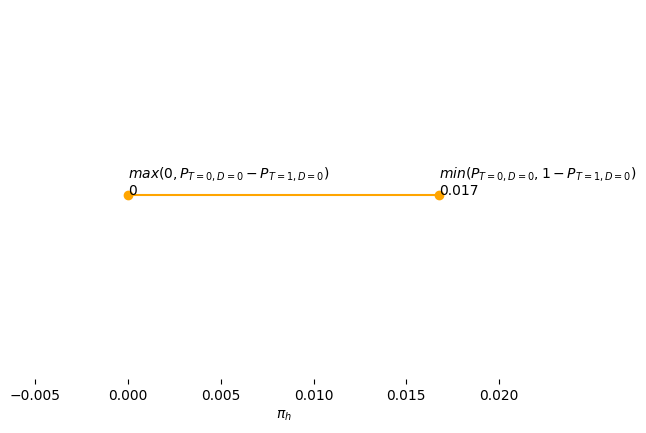

pi_h 0.0:
            LB: 1st intagral: -9.71 to -8.82. 2nd intagral: -9.854793619759928 to -8.85.
            UB: 1st intagral: -9.71 to -8.71. 2nd intagral: -9.854793619759928 to -8.85. 
            Zhang and Rubin bounds are [8.858640232439779e-20, 9.811905586216454e-19]
            
pi_h 0.001:
            LB: 1st intagral: -9.71 to -8.82. 2nd intagral: -9.854793619759928 to -8.85.
            UB: 1st intagral: -9.71 to -8.71. 2nd intagral: -9.854793619759928 to -8.86. 
            Zhang and Rubin bounds are [8.275398454972273e-20, 9.854749001945539e-19]
            
pi_h 0.002:
            LB: 1st intagral: -9.71 to -8.82. 2nd intagral: -9.854793619759928 to -8.85.
            UB: 1st intagral: -9.71 to -8.71. 2nd intagral: -9.854793619759928 to -8.86. 
            Zhang and Rubin bounds are [7.698053014426562e-20, 9.897218024842102e-19]
            
pi_h 0.003:
            LB: 1st intagral: -9.71 to -8.82. 2nd intagral: -9.854793619759928 to -8.85.
            UB: 1st intagral: -

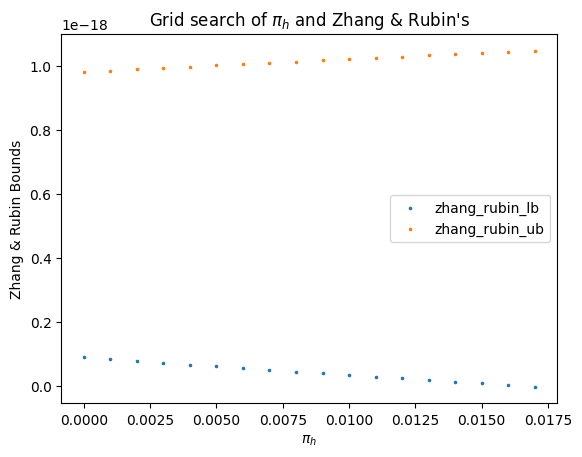

x is: -0.01


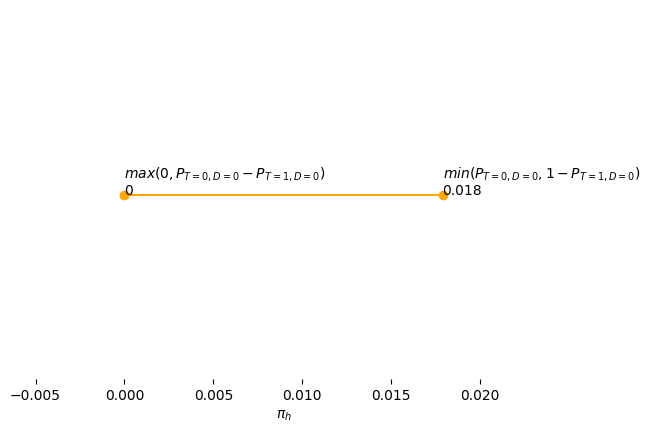

pi_h 0.0:
            LB: 1st intagral: -9.98 to -9.09. 2nd intagral: -9.988994023569543 to -8.99.
            UB: 1st intagral: -9.98 to -8.98. 2nd intagral: -9.988994023569543 to -8.99. 
            Zhang and Rubin bounds are [-7.34607235568424e-20, 1.168573968287808e-20]
            
pi_h 0.001:
            LB: 1st intagral: -9.98 to -9.09. 2nd intagral: -9.988994023569543 to -8.99.
            UB: 1st intagral: -9.98 to -8.98. 2nd intagral: -9.988994023569543 to -8.99. 
            Zhang and Rubin bounds are [-7.395759683338478e-20, 1.2991032087524335e-20]
            
pi_h 0.002:
            LB: 1st intagral: -9.98 to -9.09. 2nd intagral: -9.988994023569543 to -8.99.
            UB: 1st intagral: -9.98 to -8.98. 2nd intagral: -9.988994023569543 to -8.99. 
            Zhang and Rubin bounds are [-7.44491898298148e-20, 1.4284636799612793e-20]
            
pi_h 0.003:
            LB: 1st intagral: -9.98 to -9.1. 2nd intagral: -9.988994023569543 to -8.99.
            UB: 1st intagral:

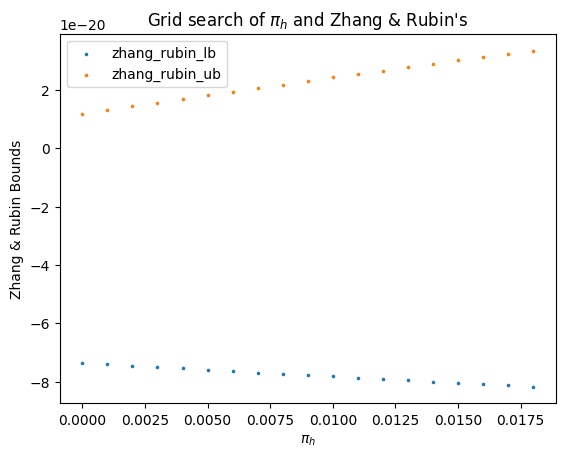

x is: 0.02


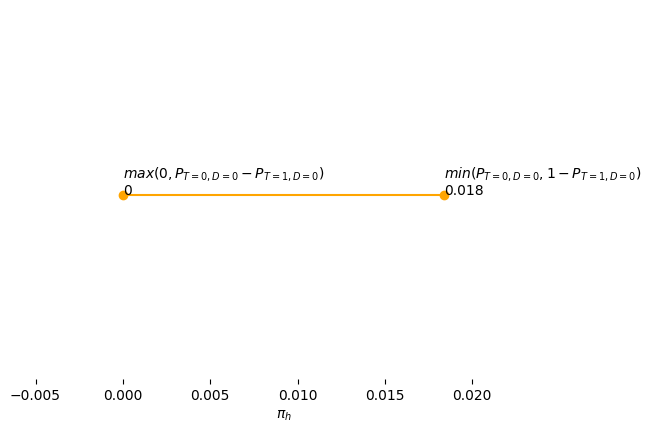

pi_h 0.0:
            LB: 1st intagral: -0.09 to 0.79. 2nd intagral: nan to nan.
            UB: 1st intagral: -0.09 to 0.91. 2nd intagral: nan to nan. 
            Zhang and Rubin bounds are [nan, nan]
            
pi_h 0.001:
            LB: 1st intagral: -0.09 to 0.79. 2nd intagral: nan to nan.
            UB: 1st intagral: -0.09 to 0.91. 2nd intagral: nan to nan. 
            Zhang and Rubin bounds are [nan, nan]
            
pi_h 0.002:
            LB: 1st intagral: -0.09 to 0.79. 2nd intagral: nan to nan.
            UB: 1st intagral: -0.09 to 0.91. 2nd intagral: nan to nan. 
            Zhang and Rubin bounds are [nan, nan]
            
pi_h 0.003:
            LB: 1st intagral: -0.09 to 0.79. 2nd intagral: nan to nan.
            UB: 1st intagral: -0.09 to 0.91. 2nd intagral: nan to nan. 
            Zhang and Rubin bounds are [nan, nan]
            
pi_h 0.004:
            LB: 1st intagral: -0.09 to 0.79. 2nd intagral: nan to nan.
            UB: 1st intagral: -0.09 to 0.91. 2n

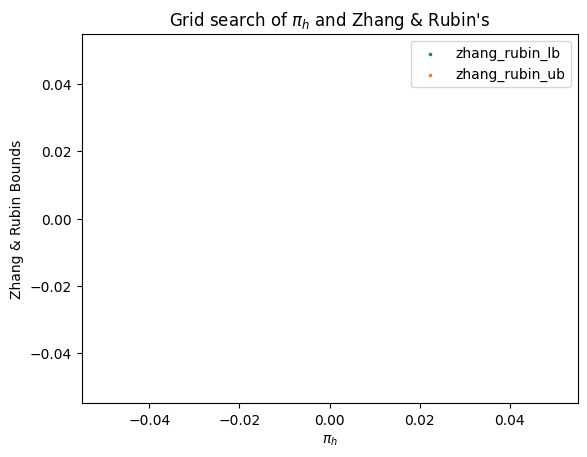

x is: 0.08


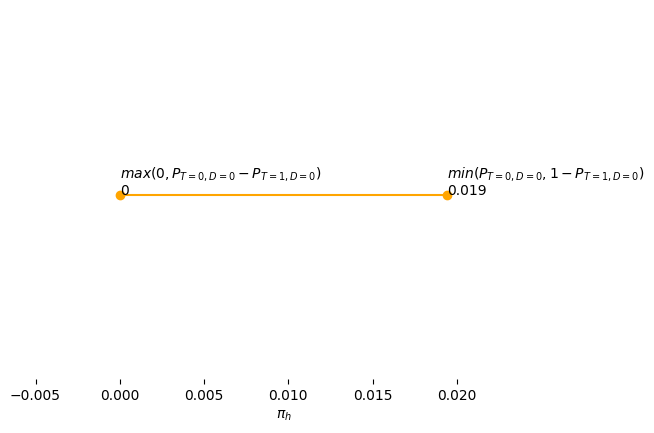

pi_h 0.0:
            LB: 1st intagral: -0.31 to 0.56. 2nd intagral: nan to nan.
            UB: 1st intagral: -0.31 to 0.69. 2nd intagral: nan to nan. 
            Zhang and Rubin bounds are [nan, nan]
            
pi_h 0.001:
            LB: 1st intagral: -0.31 to 0.56. 2nd intagral: nan to nan.
            UB: 1st intagral: -0.31 to 0.69. 2nd intagral: nan to nan. 
            Zhang and Rubin bounds are [nan, nan]
            
pi_h 0.002:
            LB: 1st intagral: -0.31 to 0.56. 2nd intagral: nan to nan.
            UB: 1st intagral: -0.31 to 0.69. 2nd intagral: nan to nan. 
            Zhang and Rubin bounds are [nan, nan]
            
pi_h 0.003:
            LB: 1st intagral: -0.31 to 0.56. 2nd intagral: nan to nan.
            UB: 1st intagral: -0.31 to 0.69. 2nd intagral: nan to nan. 
            Zhang and Rubin bounds are [nan, nan]
            
pi_h 0.004:
            LB: 1st intagral: -0.31 to 0.56. 2nd intagral: nan to nan.
            UB: 1st intagral: -0.31 to 0.69. 2n

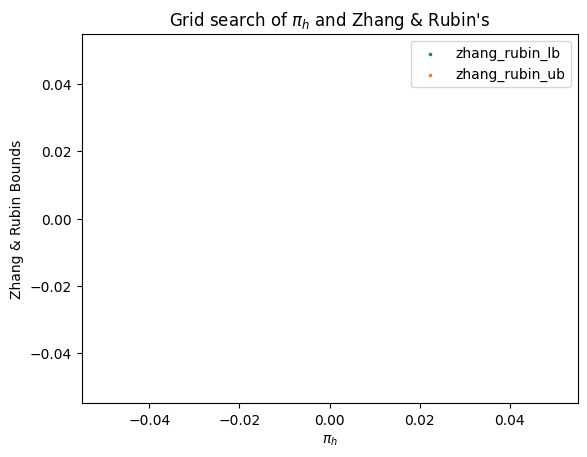

x is: 0.13


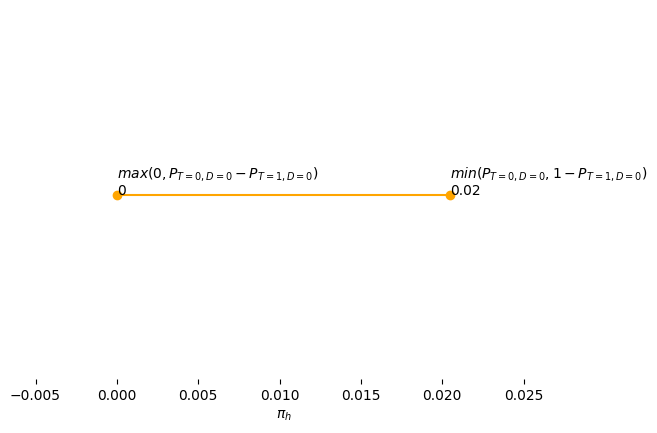

pi_h 0.0:
            LB: 1st intagral: -0.53 to 0.34. 2nd intagral: nan to nan.
            UB: 1st intagral: -0.53 to 0.47. 2nd intagral: nan to nan. 
            Zhang and Rubin bounds are [nan, nan]
            
pi_h 0.001:
            LB: 1st intagral: -0.53 to 0.34. 2nd intagral: nan to nan.
            UB: 1st intagral: -0.53 to 0.47. 2nd intagral: nan to nan. 
            Zhang and Rubin bounds are [nan, nan]
            
pi_h 0.002:
            LB: 1st intagral: -0.53 to 0.34. 2nd intagral: nan to nan.
            UB: 1st intagral: -0.53 to 0.47. 2nd intagral: nan to nan. 
            Zhang and Rubin bounds are [nan, nan]
            
pi_h 0.003:
            LB: 1st intagral: -0.53 to 0.33. 2nd intagral: nan to nan.
            UB: 1st intagral: -0.53 to 0.47. 2nd intagral: nan to nan. 
            Zhang and Rubin bounds are [nan, nan]
            
pi_h 0.004:
            LB: 1st intagral: -0.53 to 0.33. 2nd intagral: nan to nan.
            UB: 1st intagral: -0.53 to 0.47. 2n

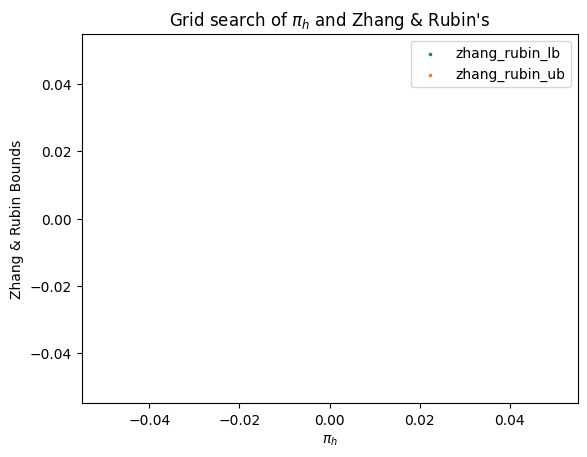

x is: 0.17


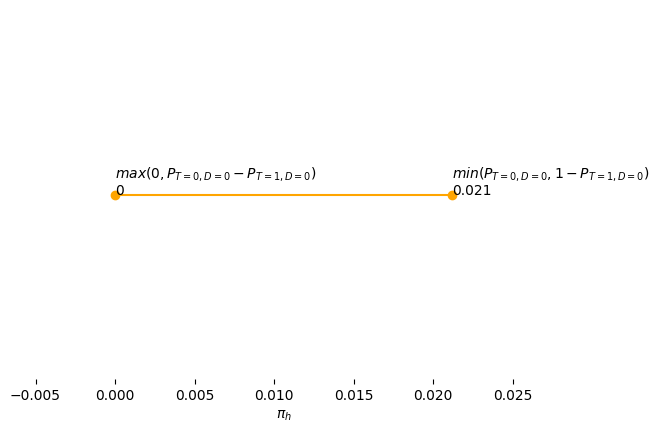

pi_h 0.0:
            LB: 1st intagral: -10.67 to -9.8. 2nd intagral: -10.334624447403488 to -9.33.
            UB: 1st intagral: -10.67 to -9.67. 2nd intagral: -10.334624447403488 to -9.33. 
            Zhang and Rubin bounds are [-4.495341063772686e-21, -4.35340542607748e-21]
            
pi_h 0.001:
            LB: 1st intagral: -10.67 to -9.81. 2nd intagral: -10.334624447403488 to -9.33.
            UB: 1st intagral: -10.67 to -9.67. 2nd intagral: -10.334624447403488 to -9.34. 
            Zhang and Rubin bounds are [-4.495943738334204e-21, -4.296987468964748e-21]
            
pi_h 0.002:
            LB: 1st intagral: -10.67 to -9.81. 2nd intagral: -10.334624447403488 to -9.33.
            UB: 1st intagral: -10.67 to -9.67. 2nd intagral: -10.334624447403488 to -9.34. 
            Zhang and Rubin bounds are [-4.4965391337626485e-21, -4.241107897654951e-21]
            
pi_h 0.003:
            LB: 1st intagral: -10.67 to -9.81. 2nd intagral: -10.334624447403488 to -9.33.
            

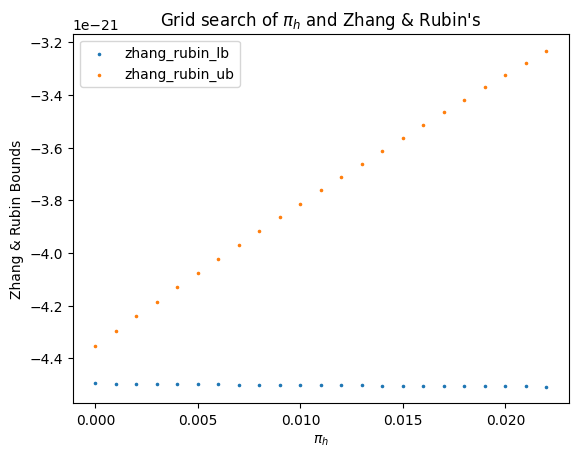

x is: 0.18
** including the non parametric bounds **


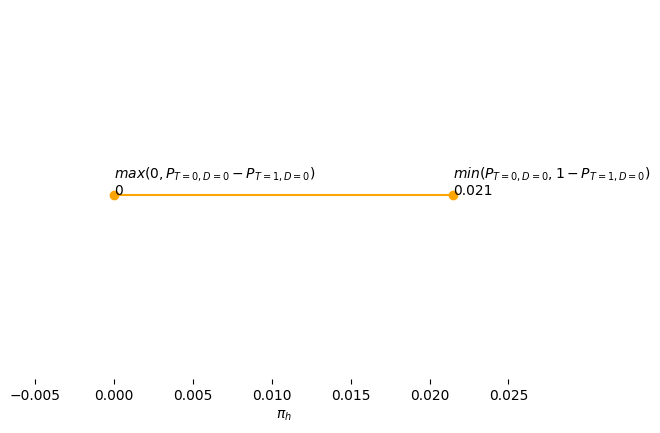

pi_h 0.0:
            LB: 1st intagral: -10.72 to -9.86. 2nd intagral: -10.36117977005923 to -9.36.
            UB: 1st intagral: -10.72 to -9.72. 2nd intagral: -10.36117977005923 to -9.36. 
            Zhang and Rubin bounds are [-3.506729566001973e-21, -3.421672430694016e-21]
            
pi_h 0.001:
            LB: 1st intagral: -10.72 to -9.86. 2nd intagral: -10.36117977005923 to -9.36.
            UB: 1st intagral: -10.72 to -9.72. 2nd intagral: -10.36117977005923 to -9.36. 
            Zhang and Rubin bounds are [-3.507081367308308e-21, -3.3775639495683887e-21]
            
pi_h 0.002:
            LB: 1st intagral: -10.72 to -9.86. 2nd intagral: -10.36117977005923 to -9.36.
            UB: 1st intagral: -10.72 to -9.72. 2nd intagral: -10.36117977005923 to -9.36. 
            Zhang and Rubin bounds are [-3.507428877552557e-21, -3.3338784809634214e-21]
            
pi_h 0.003:
            LB: 1st intagral: -10.72 to -9.86. 2nd intagral: -10.36117977005923 to -9.36.
            UB: 

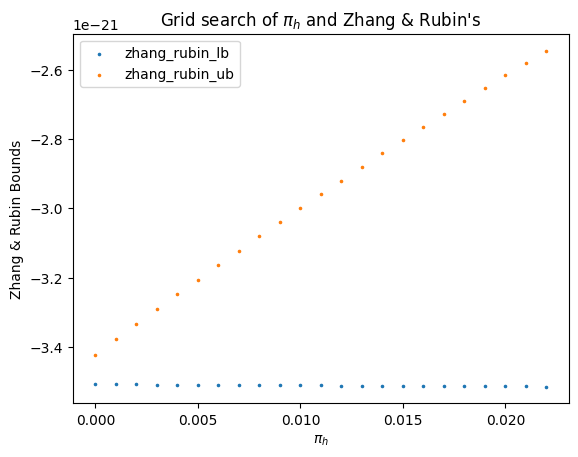

x is: 0.23


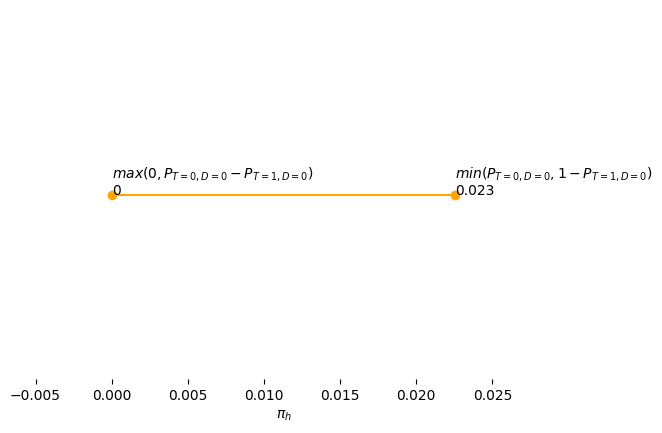

pi_h 0.0:
            LB: 1st intagral: -10.93 to -10.07. 2nd intagral: -10.463400392208866 to -9.46.
            UB: 1st intagral: -10.93 to -9.93. 2nd intagral: -10.463400392208866 to -9.46. 
            Zhang and Rubin bounds are [-1.3334739089699914e-21, -1.3219451710407882e-21]
            
pi_h 0.001:
            LB: 1st intagral: -10.93 to -10.07. 2nd intagral: -10.463400392208866 to -9.46.
            UB: 1st intagral: -10.93 to -9.93. 2nd intagral: -10.463400392208866 to -9.46. 
            Zhang and Rubin bounds are [-1.3335168885108985e-21, -1.3049514723736675e-21]
            
pi_h 0.002:
            LB: 1st intagral: -10.93 to -10.07. 2nd intagral: -10.463400392208866 to -9.46.
            UB: 1st intagral: -10.93 to -9.93. 2nd intagral: -10.463400392208866 to -9.47. 
            Zhang and Rubin bounds are [-1.3335593235504639e-21, -1.2881239082054199e-21]
            
pi_h 0.003:
            LB: 1st intagral: -10.93 to -10.08. 2nd intagral: -10.463400392208866 to -9.46.
 

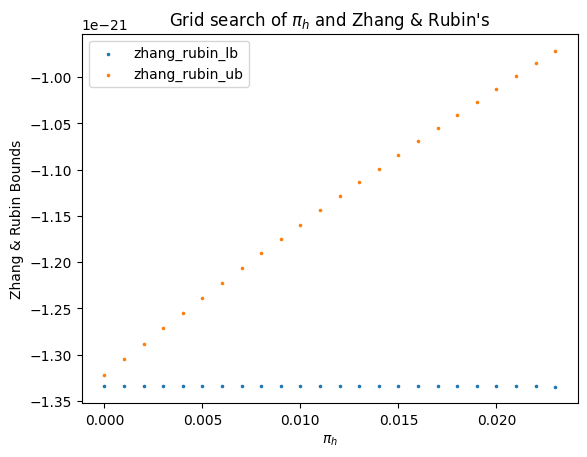

x is: 0.36


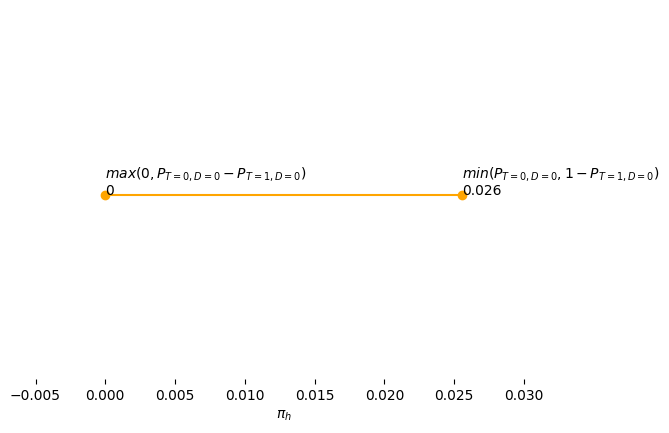

pi_h 0.0:
            LB: 1st intagral: -11.43 to -10.6. 2nd intagral: -10.71640927657796 to -9.72.
            UB: 1st intagral: -11.43 to -10.43. 2nd intagral: -10.71640927657796 to -9.72. 
            Zhang and Rubin bounds are [-1.1538335133829077e-22, -1.1531539297198831e-22]
            
pi_h 0.001:
            LB: 1st intagral: -11.43 to -10.6. 2nd intagral: -10.71640927657796 to -9.72.
            UB: 1st intagral: -11.43 to -10.43. 2nd intagral: -10.71640927657796 to -9.72. 
            Zhang and Rubin bounds are [-1.153835431665966e-22, -1.1378002173383017e-22]
            
pi_h 0.002:
            LB: 1st intagral: -11.43 to -10.6. 2nd intagral: -10.71640927657796 to -9.72.
            UB: 1st intagral: -11.43 to -10.43. 2nd intagral: -10.71640927657796 to -9.72. 
            Zhang and Rubin bounds are [-1.1538373232353506e-22, -1.1226040424969413e-22]
            
pi_h 0.003:
            LB: 1st intagral: -11.43 to -10.6. 2nd intagral: -10.71640927657796 to -9.72.
          

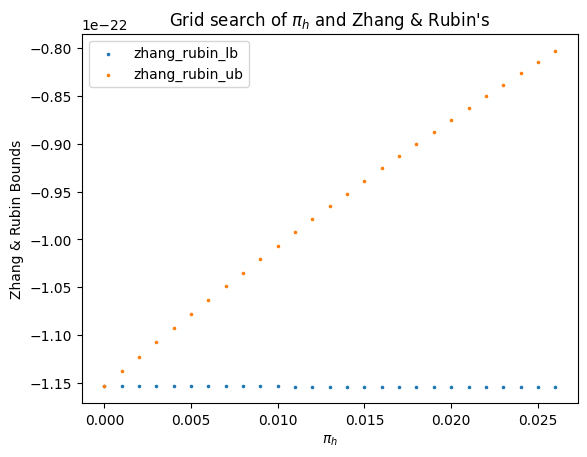

x is: 0.65


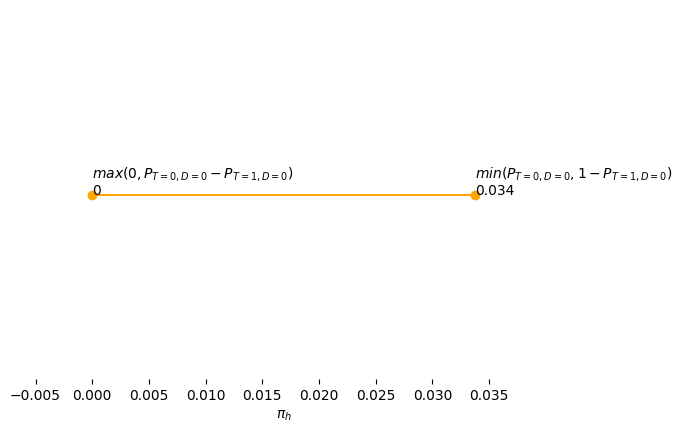

pi_h 0.0:
            LB: 1st intagral: -12.58 to -11.8. 2nd intagral: -11.290148971692677 to -10.29.
            UB: 1st intagral: -12.58 to -11.58. 2nd intagral: -11.290148971692677 to -10.29. 
            Zhang and Rubin bounds are [-3.5303562389081104e-25, -3.5303540100810888e-25]
            
pi_h 0.001:
            LB: 1st intagral: -12.58 to -11.8. 2nd intagral: -11.290148971692677 to -10.29.
            UB: 1st intagral: -12.58 to -11.58. 2nd intagral: -11.290148971692677 to -10.29. 
            Zhang and Rubin bounds are [-3.530356241804949e-25, -3.477888810579751e-25]
            
pi_h 0.002:
            LB: 1st intagral: -12.58 to -11.8. 2nd intagral: -11.290148971692677 to -10.29.
            UB: 1st intagral: -12.58 to -11.58. 2nd intagral: -11.290148971692677 to -10.29. 
            Zhang and Rubin bounds are [-3.5303562446514656e-25, -3.426027577118132e-25]
            
pi_h 0.003:
            LB: 1st intagral: -12.58 to -11.8. 2nd intagral: -11.290148971692677 to -10.29

pi_h 0.028:
            LB: 1st intagral: -12.58 to -11.84. 2nd intagral: -11.290148971692677 to -10.29.
            UB: 1st intagral: -12.58 to -11.58. 2nd intagral: -11.290148971692677 to -10.33. 
            Zhang and Rubin bounds are [-3.5303563032119607e-25, -2.274711655043612e-25]
            
pi_h 0.029:
            LB: 1st intagral: -12.58 to -11.84. 2nd intagral: -11.290148971692677 to -10.29.
            UB: 1st intagral: -12.58 to -11.58. 2nd intagral: -11.290148971692677 to -10.33. 
            Zhang and Rubin bounds are [-3.5303563049484235e-25, -2.237448664356966e-25]
            
pi_h 0.03:
            LB: 1st intagral: -12.58 to -11.84. 2nd intagral: -11.290148971692677 to -10.29.
            UB: 1st intagral: -12.58 to -11.58. 2nd intagral: -11.290148971692677 to -10.33. 
            Zhang and Rubin bounds are [-3.5303563066519945e-25, -2.200664927378969e-25]
            
pi_h 0.031:
            LB: 1st intagral: -12.58 to -11.85. 2nd intagral: -11.290148971692677 to -

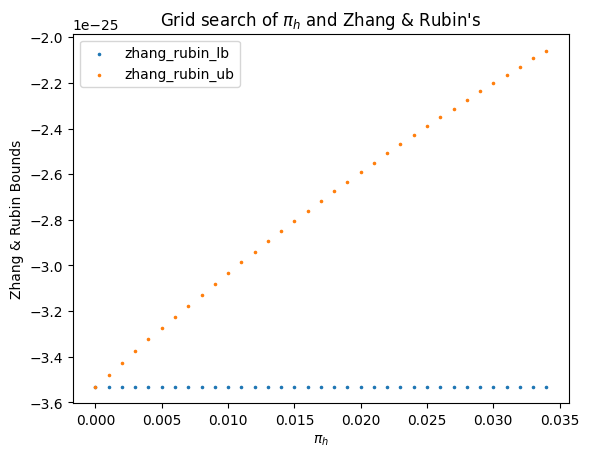

x is: 0.75


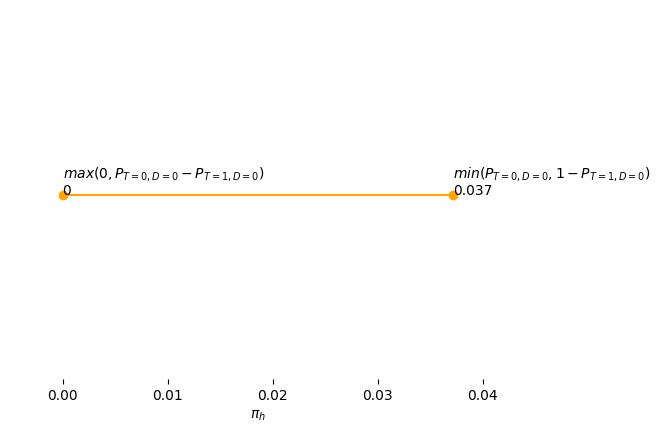

pi_h 0.0:
            LB: 1st intagral: -12.99 to -12.23. 2nd intagral: -11.494314496427108 to -10.49.
            UB: 1st intagral: -12.99 to -11.99. 2nd intagral: -11.494314496427108 to -10.49. 
            Zhang and Rubin bounds are [-4.1575658348310957e-26, -4.157565655453353e-26]
            
pi_h 0.001:
            LB: 1st intagral: -12.99 to -12.23. 2nd intagral: -11.494314496427108 to -10.49.
            UB: 1st intagral: -12.99 to -11.99. 2nd intagral: -11.494314496427108 to -10.5. 
            Zhang and Rubin bounds are [-4.1575658349970906e-26, -4.093097991203623e-26]
            
pi_h 0.002:
            LB: 1st intagral: -12.99 to -12.23. 2nd intagral: -11.494314496427108 to -10.49.
            UB: 1st intagral: -12.99 to -11.99. 2nd intagral: -11.494314496427108 to -10.5. 
            Zhang and Rubin bounds are [-4.1575658351599557e-26, -4.029405205795682e-26]
            
pi_h 0.003:
            LB: 1st intagral: -12.99 to -12.23. 2nd intagral: -11.494314496427108 to -10.

pi_h 0.028:
            LB: 1st intagral: -12.99 to -12.27. 2nd intagral: -11.494314496427108 to -10.49.
            UB: 1st intagral: -12.99 to -11.99. 2nd intagral: -11.494314496427108 to -10.53. 
            Zhang and Rubin bounds are [-4.1575658384460134e-26, -2.6253858824876314e-26]
            
pi_h 0.029:
            LB: 1st intagral: -12.99 to -12.27. 2nd intagral: -11.494314496427108 to -10.49.
            UB: 1st intagral: -12.99 to -11.99. 2nd intagral: -11.494314496427108 to -10.53. 
            Zhang and Rubin bounds are [-4.157565838541177e-26, -2.5803256933478395e-26]
            
pi_h 0.03:
            LB: 1st intagral: -12.99 to -12.28. 2nd intagral: -11.494314496427108 to -10.49.
            UB: 1st intagral: -12.99 to -11.99. 2nd intagral: -11.494314496427108 to -10.54. 
            Zhang and Rubin bounds are [-4.15756583863438e-26, -2.5358734662964898e-26]
            
pi_h 0.031:
            LB: 1st intagral: -12.99 to -12.28. 2nd intagral: -11.494314496427108 to -

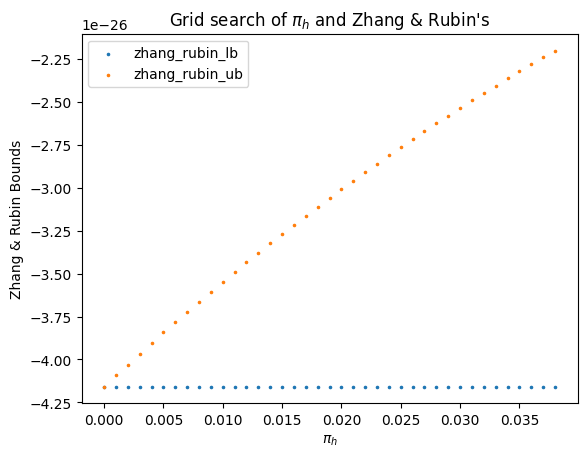

x is: 0.82


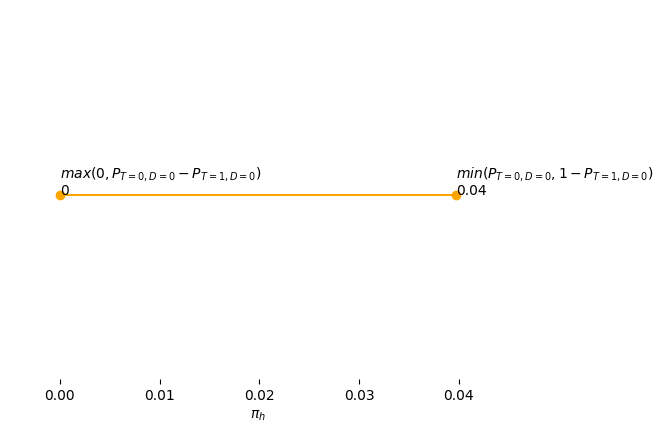

pi_h 0.0:
            LB: 1st intagral: -3.26 to -2.51. 2nd intagral: nan to nan.
            UB: 1st intagral: -3.26 to -2.26. 2nd intagral: nan to nan. 
            Zhang and Rubin bounds are [nan, nan]
            
pi_h 0.001:
            LB: 1st intagral: -3.26 to -2.52. 2nd intagral: nan to nan.
            UB: 1st intagral: -3.26 to -2.26. 2nd intagral: nan to nan. 
            Zhang and Rubin bounds are [nan, nan]
            
pi_h 0.002:
            LB: 1st intagral: -3.26 to -2.52. 2nd intagral: nan to nan.
            UB: 1st intagral: -3.26 to -2.26. 2nd intagral: nan to nan. 
            Zhang and Rubin bounds are [nan, nan]
            
pi_h 0.003:
            LB: 1st intagral: -3.26 to -2.52. 2nd intagral: nan to nan.
            UB: 1st intagral: -3.26 to -2.26. 2nd intagral: nan to nan. 
            Zhang and Rubin bounds are [nan, nan]
            
pi_h 0.004:
            LB: 1st intagral: -3.26 to -2.52. 2nd intagral: nan to nan.
            UB: 1st intagral: -3.26 to

pi_h 0.04:
            LB: 1st intagral: -3.26 to -2.58. 2nd intagral: nan to nan.
            UB: 1st intagral: -3.26 to -2.26. 2nd intagral: nan to nan. 
            Zhang and Rubin bounds are [nan, nan]
            
mu_y_1_x-mu_y_0_x: nan
Zhang and Rubins bounds: [nan, nan]


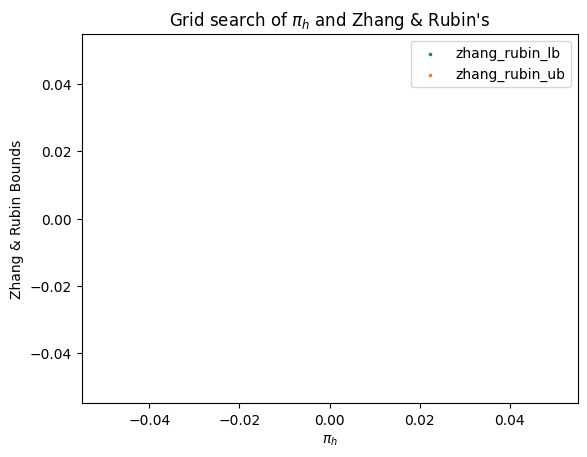

x is: 0.83


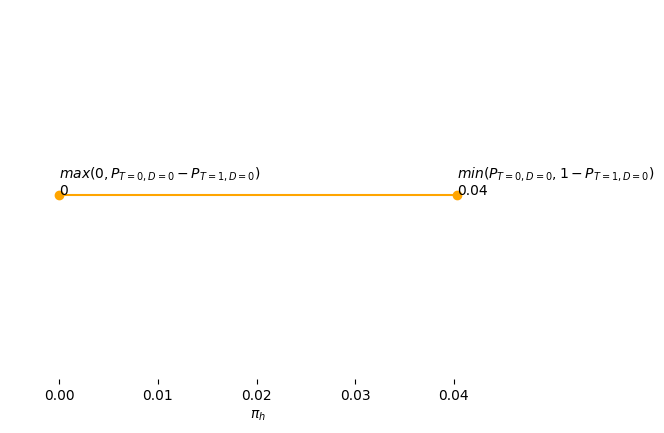

pi_h 0.0:
            LB: 1st intagral: -13.32 to -12.58. 2nd intagral: -11.659457560881794 to -10.66.
            UB: 1st intagral: -13.32 to -12.32. 2nd intagral: -11.659457560881794 to -10.66. 
            Zhang and Rubin bounds are [-7.149303958438873e-27, -7.149303926429393e-27]
            
pi_h 0.001:
            LB: 1st intagral: -13.32 to -12.58. 2nd intagral: -11.659457560881794 to -10.66.
            UB: 1st intagral: -13.32 to -12.32. 2nd intagral: -11.659457560881794 to -10.66. 
            Zhang and Rubin bounds are [-7.149303958460691e-27, -7.034414068002517e-27]
            
pi_h 0.002:
            LB: 1st intagral: -13.32 to -12.58. 2nd intagral: -11.659457560881794 to -10.66.
            UB: 1st intagral: -13.32 to -12.32. 2nd intagral: -11.659457560881794 to -10.66. 
            Zhang and Rubin bounds are [-7.14930395848207e-27, -6.920955665441853e-27]
            
pi_h 0.003:
            LB: 1st intagral: -13.32 to -12.58. 2nd intagral: -11.659457560881794 to -10.66

pi_h 0.033:
            LB: 1st intagral: -13.32 to -12.63. 2nd intagral: -11.659457560881794 to -10.66.
            UB: 1st intagral: -13.32 to -12.32. 2nd intagral: -11.659457560881794 to -10.71. 
            Zhang and Rubin bounds are [-7.149303958963515e-27, -4.0502886253807766e-27]
            
pi_h 0.034:
            LB: 1st intagral: -13.32 to -12.64. 2nd intagral: -11.659457560881794 to -10.66.
            UB: 1st intagral: -13.32 to -12.32. 2nd intagral: -11.659457560881794 to -10.71. 
            Zhang and Rubin bounds are [-7.149303958974256e-27, -3.976553492756936e-27]
            
pi_h 0.035:
            LB: 1st intagral: -13.32 to -12.64. 2nd intagral: -11.659457560881794 to -10.66.
            UB: 1st intagral: -13.32 to -12.32. 2nd intagral: -11.659457560881794 to -10.71. 
            Zhang and Rubin bounds are [-7.149303958984756e-27, -3.903877081834313e-27]
            
pi_h 0.036:
            LB: 1st intagral: -13.32 to -12.64. 2nd intagral: -11.659457560881794 to -1

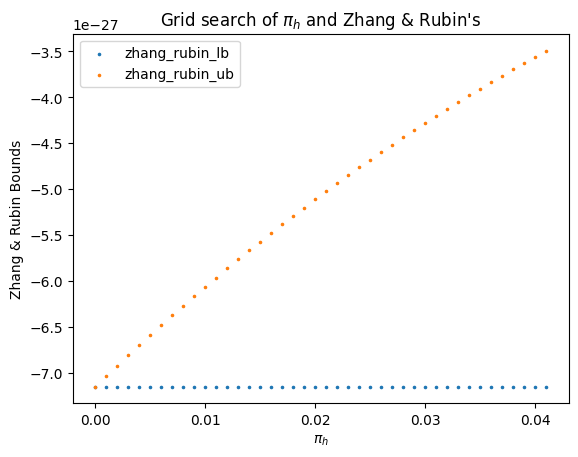

x is: 0.87


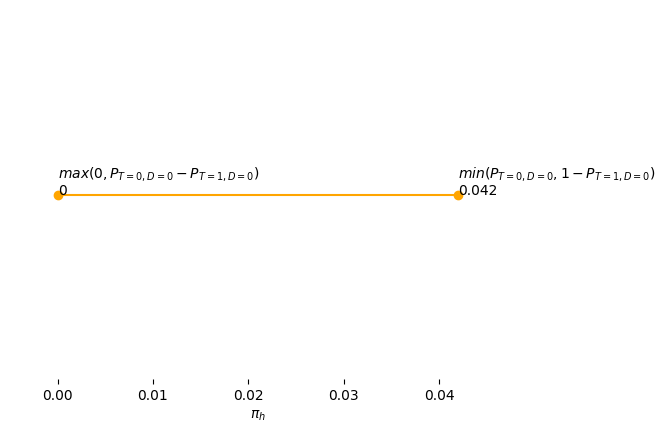

pi_h 0.0:
            LB: 1st intagral: -13.49 to -12.76. 2nd intagral: -11.747318957299033 to -10.75.
            UB: 1st intagral: -13.49 to -12.49. 2nd intagral: -11.747318957299033 to -10.75. 
            Zhang and Rubin bounds are [-2.771343274336162e-27, -2.771343270744879e-27]
            
pi_h 0.001:
            LB: 1st intagral: -13.49 to -12.76. 2nd intagral: -11.747318957299033 to -10.75.
            UB: 1st intagral: -13.49 to -12.49. 2nd intagral: -11.747318957299033 to -10.75. 
            Zhang and Rubin bounds are [-2.7713432743382163e-27, -2.725929154686673e-27]
            
pi_h 0.002:
            LB: 1st intagral: -13.49 to -12.77. 2nd intagral: -11.747318957299033 to -10.75.
            UB: 1st intagral: -13.49 to -12.49. 2nd intagral: -11.747318957299033 to -10.75. 
            Zhang and Rubin bounds are [-2.7713432743402277e-27, -2.6810920172695753e-27]
            
pi_h 0.003:
            LB: 1st intagral: -13.49 to -12.77. 2nd intagral: -11.747318957299033 to -1

pi_h 0.03:
            LB: 1st intagral: -13.49 to -12.82. 2nd intagral: -11.747318957299033 to -10.75.
            UB: 1st intagral: -13.49 to -12.49. 2nd intagral: -11.747318957299033 to -10.79. 
            Zhang and Rubin bounds are [-2.771343274381912e-27, -1.6404603951607783e-27]
            
pi_h 0.031:
            LB: 1st intagral: -13.49 to -12.82. 2nd intagral: -11.747318957299033 to -10.75.
            UB: 1st intagral: -13.49 to -12.49. 2nd intagral: -11.747318957299033 to -10.79. 
            Zhang and Rubin bounds are [-2.7713432743829678e-27, -1.6102902284891742e-27]
            
pi_h 0.032:
            LB: 1st intagral: -13.49 to -12.82. 2nd intagral: -11.747318957299033 to -10.75.
            UB: 1st intagral: -13.49 to -12.49. 2nd intagral: -11.747318957299033 to -10.79. 
            Zhang and Rubin bounds are [-2.771343274383999e-27, -1.5805571606555477e-27]
            
pi_h 0.033:
            LB: 1st intagral: -13.49 to -12.82. 2nd intagral: -11.747318957299033 to 

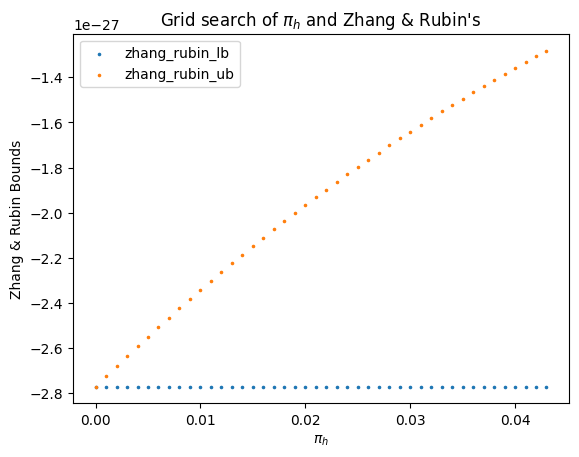

x is: 0.97
** including the non parametric bounds **


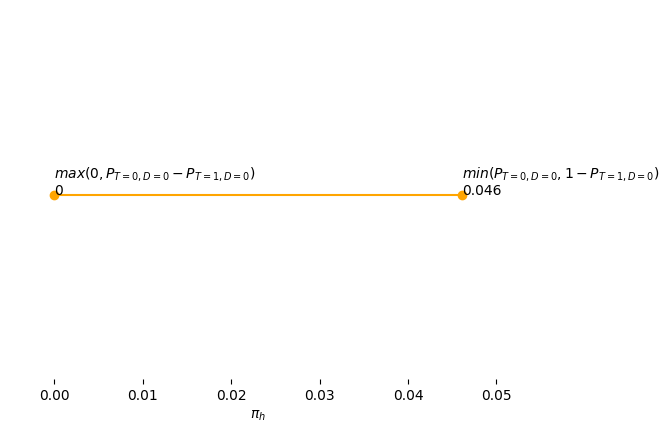

pi_h 0.0:
            LB: 1st intagral: -13.88 to -13.17. 2nd intagral: -11.939364795849338 to -10.94.
            UB: 1st intagral: -13.88 to -12.88. 2nd intagral: -11.939364795849338 to -10.94. 
            Zhang and Rubin bounds are [-3.4000390645647357e-28, -3.400039064294923e-28]
            
pi_h 0.001:
            LB: 1st intagral: -13.88 to -13.17. 2nd intagral: -11.939364795849338 to -10.94.
            UB: 1st intagral: -13.88 to -12.88. 2nd intagral: -11.939364795849338 to -10.94. 
            Zhang and Rubin bounds are [-3.400039064564837e-28, -3.3418144514040824e-28]
            
pi_h 0.002:
            LB: 1st intagral: -13.88 to -13.18. 2nd intagral: -11.939364795849338 to -10.94.
            UB: 1st intagral: -13.88 to -12.88. 2nd intagral: -11.939364795849338 to -10.94. 
            Zhang and Rubin bounds are [-3.4000390645649365e-28, -3.284362578494961e-28]
            
pi_h 0.003:
            LB: 1st intagral: -13.88 to -13.18. 2nd intagral: -11.939364795849338 to -1

pi_h 0.028:
            LB: 1st intagral: -13.88 to -13.22. 2nd intagral: -11.939364795849338 to -10.94.
            UB: 1st intagral: -13.88 to -12.88. 2nd intagral: -11.939364795849338 to -10.98. 
            Zhang and Rubin bounds are [-3.4000390645668437e-28, -2.0399017963569103e-28]
            
pi_h 0.029:
            LB: 1st intagral: -13.88 to -13.23. 2nd intagral: -11.939364795849338 to -10.94.
            UB: 1st intagral: -13.88 to -12.88. 2nd intagral: -11.939364795849338 to -10.98. 
            Zhang and Rubin bounds are [-3.4000390645668957e-28, -2.0008029795578976e-28]
            
pi_h 0.03:
            LB: 1st intagral: -13.88 to -13.23. 2nd intagral: -11.939364795849338 to -10.94.
            UB: 1st intagral: -13.88 to -12.88. 2nd intagral: -11.939364795849338 to -10.98. 
            Zhang and Rubin bounds are [-3.4000390645669463e-28, -1.962294134169435e-28]
            
pi_h 0.031:
            LB: 1st intagral: -13.88 to -13.23. 2nd intagral: -11.939364795849338 to

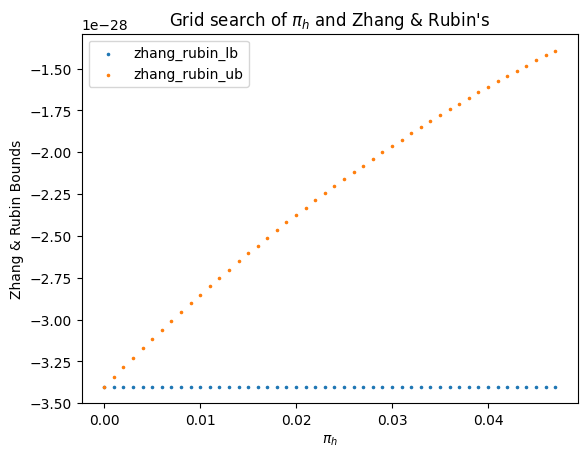

x is: 0.97


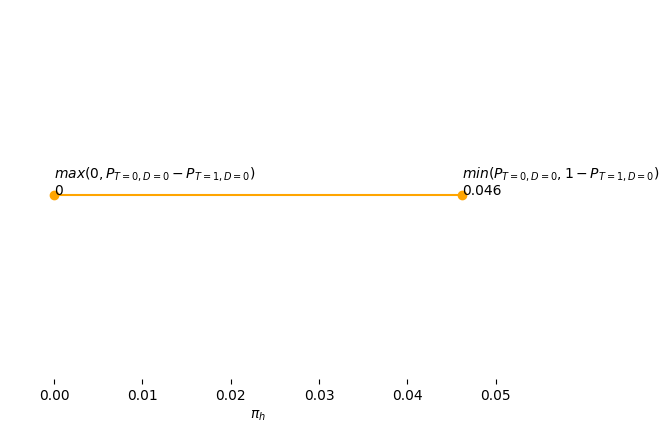

pi_h 0.0:
            LB: 1st intagral: -13.89 to -13.18. 2nd intagral: -11.944004255291484 to -10.94.
            UB: 1st intagral: -13.89 to -12.89. 2nd intagral: -11.944004255291484 to -10.94. 
            Zhang and Rubin bounds are [-3.2305318631320064e-28, -3.230531862892708e-28]
            
pi_h 0.001:
            LB: 1st intagral: -13.89 to -13.18. 2nd intagral: -11.944004255291484 to -10.94.
            UB: 1st intagral: -13.89 to -12.89. 2nd intagral: -11.944004255291484 to -10.95. 
            Zhang and Rubin bounds are [-3.2305318631320956e-28, -3.175149832857744e-28]
            
pi_h 0.002:
            LB: 1st intagral: -13.89 to -13.19. 2nd intagral: -11.944004255291484 to -10.94.
            UB: 1st intagral: -13.89 to -12.89. 2nd intagral: -11.944004255291484 to -10.95. 
            Zhang and Rubin bounds are [-3.2305318631321826e-28, -3.1205036060358277e-28]
            
pi_h 0.003:
            LB: 1st intagral: -13.89 to -13.19. 2nd intagral: -11.944004255291484 to -

pi_h 0.034:
            LB: 1st intagral: -13.89 to -13.25. 2nd intagral: -11.944004255291484 to -10.94.
            UB: 1st intagral: -13.89 to -12.89. 2nd intagral: -11.944004255291484 to -11.0. 
            Zhang and Rubin bounds are [-3.2305318631341113e-28, -1.7223221687098997e-28]
            
pi_h 0.035:
            LB: 1st intagral: -13.89 to -13.25. 2nd intagral: -11.944004255291484 to -10.94.
            UB: 1st intagral: -13.89 to -12.89. 2nd intagral: -11.944004255291484 to -11.0. 
            Zhang and Rubin bounds are [-3.2305318631341503e-28, -1.6884313280187252e-28]
            
pi_h 0.036:
            LB: 1st intagral: -13.89 to -13.25. 2nd intagral: -11.944004255291484 to -10.94.
            UB: 1st intagral: -13.89 to -12.89. 2nd intagral: -11.944004255291484 to -11.0. 
            Zhang and Rubin bounds are [-3.2305318631341884e-28, -1.65506724295548e-28]
            
pi_h 0.037:
            LB: 1st intagral: -13.89 to -13.25. 2nd intagral: -11.944004255291484 to -1

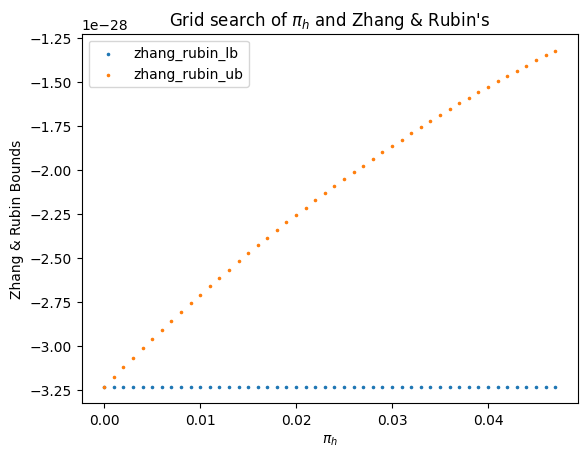

In [37]:
def pi_h_and_bounds_plots_controller(df: pd.DataFrame) -> None:
    df_for_analysis = df.sample(n=40, random_state=1).sort_values(by="x")
    for i,row in df_for_analysis.iterrows():
        print(f"x is: {round(row.x,2)}")
        calc_non_parametric = not(i % 10)
        if calc_non_parametric: 
            print("** including the non parametric bounds **")
        calc_zhang_rubin_bounds_per_x(x=row.x, plot_and_print=True, mu_y_0_x=row.mu0, mu_y_1_x=row.mu1, sigma_0=row.sigma_0, sigma_1=row.sigma_1, beta_d=row.beta_d, calc_non_parametric=calc_non_parametric)
    # zr_as_cate_bound_for_given_x = calc_zhang_rubin_bounds_per_x(x=0.0065, plot_and_print=True, beta_d = [5.0, -10.0, 6.0])

pi_h_and_bounds_plots_controller(sample_for_y_dist)

TODO - Note that some pi's don't have the integral solution <br>
TODO - check the $\mu$ inside the integral vs outside, should be the same (for given bounds)<br>

##### Parametric bounds

In [ ]:
def calc_zhang_rubin_bounds(df: pd.DataFrame) -> List[Tuple[float, float]]:
    list_of_bounds = list()
    for index, row in df.iterrows():
        if index%10000==0:
            print(f"row {index} out of {df.shape[0]}")
        if row.D_obs==0: #NEW!!
            bound = calc_zhang_rubin_bounds_per_x(x=row.x, mu_y_0_x=row.mu0, mu_y_1_x=row.mu1, sigma_0=row.sigma_0, sigma_1=row.sigma_1, beta_d=row.beta_d, pi_h_step=0.01)
        list_of_bounds.append(bound)
    return list_of_bounds
zhang_rubin_bounds = calc_zhang_rubin_bounds(sample_for_y_dist)

row 0 out of 1000


/Users/hadarrosenwald/Downloads/technion/thesis/competing_risks_simulation/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  
/Users/hadarrosenwald/Downloads/technion/thesis/competing_risks_simulation/venv/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: All-NaN axis encountered
/Users/hadarrosenwald/Downloads/technion/thesis/competing_risks_simulation/venv/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: All-NaN axis encountered


In [ ]:
def plot_zhang_rubin_bounds(df: pd.DataFrame, zhang_rubin_bounds: List[Tuple[float, float]],
                            y0_dist_param: Dict[str, float] = y0_dist_param_default,
                            y1_dist_param: Dict[str, float] = y1_dist_param_default):


    df_plot_as = df.loc[df.stratum==Strata.AS.name]    
    plt.scatter(df_plot_as.x, (df_plot_as.Y1 - df_plot_as.Y0), label = "True Y1 - Y0|AS" , s=0.1)
    

    mu_y_0_x = df.mu0
    mu_y_1_x = df.mu1

    lb, up = zip(*zhang_rubin_bounds)
    print(f"lower bound: {lb}, upper bound: {up}, true value: {mu_y_1_x-mu_y_0_x}")
    plt.scatter(list(df.x), lb, label = "Lower bound", s=0.1)
    plt.scatter(list(df.x), up, label = "Upper bound", s=0.1)
    plt.scatter(list(df.x), mu_y_1_x-mu_y_0_x, label = r'$\mu_{y(1)|x}-\mu_{y(0)|x}$', s=0.1)

    plt.legend(markerscale=12)
    # plt.legend()
    plt.title("Bounding Y1-Y0|AS by Zhang and Rubin")
    plt.xlabel('X')
    plt.ylabel('Y1-Y0|AS bounds')
    plt.ylim((min(-3,min(lb)),max(3,max(up))))
    plt.show()
    return {'lb': lb, 'up': up, 'true value': mu_y_1_x-mu_y_0_x}
d = plot_zhang_rubin_bounds(sample_for_y_dist, zhang_rubin_bounds)

In [ ]:
pd.Series(d['up']).hist()
pd.Series(d['lb']).hist()

In [ ]:
# check that the bounds bounded the expected value correctly
for i,true in enumerate(d['true value']):
    if true>d['up'][i] or true<d['lb'][i]:
        print(f"bad {i}")


In [ ]:
# d['x']=sample_for_y_dist.x
# pd.DataFrame(d)
# pd.DataFrame(d).lb.min()

# SCATE(x)

In [ ]:
def plot_scate(df: pd.DataFrame,
               y0_dist_param_for_scate: Dict[str,float] = y0_dist_param_default,
               y1_dist_param_for_scate: Dict[str,float] = y1_dist_param_default):
    df_plot_as = df.loc[df.stratum==Strata.AS.name]  
    mu0 = df_plot_as.mu0
    mu1 = df_plot_as.mu1
    plt.scatter(df_plot_as.x, np.array(df_plot_as.Y1 - df_plot_as.Y0), label = "Realized Y1 - Y0", s=0.1)
    # plt.scatter(df_plot_as.x, np.array(df_plot_as.Y1 - df_plot_as.Y0), label = "Bounded Y1-Y0", s=0.1) TODO
    plt.scatter(df_plot_as.x, mu1 - mu0, label = "mu1 - mu0", s=0.1)
    plt.legend(markerscale=10)
    plt.title("SCATE as a function of X, among AS")
    plt.xlabel('X')
    plt.ylabel('SCATE')
    plt.show()

plot_scate(sample_for_y_dist)

TODO also here - do we want $\bar{Y_1}|AS-\bar{Y_0}|AS$ as function of descrete groups of X? <br>
-> + add Zhang & Rubin

# CATE(x) on D

In [ ]:
sample_for_D_CATE = create_sample()

In [ ]:
def plot_cate_on_d(omega_for_cate: float= omega_default, beta_d_for_cate: List[float] = beta_d_default):
    D0_prob = np.array([(1 / (1 + np.exp(-omega_for_cate*(beta_d_for_cate[0] + beta_d_for_cate[1]*0 + beta_d_for_cate[2]*x)))) for x in sample_for_D_CATE.x.values])
    D1_prob = np.array([(1 / (1 + np.exp(-omega_for_cate*(beta_d_for_cate[0] + beta_d_for_cate[1]*1 + beta_d_for_cate[2]*x)))) for x in sample_for_D_CATE.x.values])

    beta_hat_for_cate = estimate_beta_d_from_realizations(beta_d_for_cate, sample_for_D_CATE)
    D0_prob_hat = np.array([(1 / (1 + np.exp(-omega_for_cate*(beta_hat_for_cate[0] + beta_hat_for_cate[1]*0 + beta_hat_for_cate[2]*x)))) for x in sample_for_D_CATE.x.values])
    D1_prob_hat = np.array([(1 / (1 + np.exp(-omega_for_cate*(beta_hat_for_cate[0] + beta_hat_for_cate[1]*1 + beta_hat_for_cate[2]*x)))) for x in sample_for_D_CATE.x.values])

    plt.scatter(sample_for_D_CATE.x, np.array(sample_for_D_CATE.loc[sample_for_D_CATE.t==1].D1 - sample_for_D_CATE.loc[sample_for_D_CATE.t==0].D0), label = "D^obs among t=1 and t=0", s=0.1)
    plt.scatter(sample_for_D_CATE.x, np.array(sample_for_D_CATE.D1 - sample_for_D_CATE.D0), label = "Realized D1 - D0", s=0.1)
    plt.scatter(sample_for_D_CATE.x, D1_prob_hat - D0_prob_hat, label = "E^[D1|x] - E^[D0|x]", s=0.1)
    plt.scatter(sample_for_D_CATE.x, D1_prob - D0_prob, label = "E[D1|x] - E[D0|x]", s=0.1)
    plt.legend(markerscale=10)
    plt.title("CATE (on D) as a function of X")
    plt.xlabel('X')
    plt.ylabel('CATE on D')
    plt.show()

plot_cate_on_d()


D1-D0 can either be: 1, 0, -1. should we average on same group of x?